In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
import random   
import scipy.stats
from scipy import stats

In [2]:
import statannotations

In [3]:
import matplotlib.pyplot as plt 
import random   
import scipy
import scipy.stats
from statannotations.Annotator import Annotator

In [4]:
def RACIPE_data_import(filename):
  Network = pd.read_table(filename[:-13] + '_solution.dat', sep ='\t', index_col  = False, header = None) 
  Network_prs= pd.read_csv(filename[:-13] + '.prs', sep ='\t', index_col  = False) 

  c = ['Model Number','Stable States','Number of Runs that converged']
  p = 'P'
  i = 0

  while p =='P':
    c.append(Network_prs.iloc[i,0][8:])
    p = Network_prs.iloc[i+1,0][0]
    i = i + 1
  Network.columns= c
  return Network



In [5]:
def param(filename):
    param_file = pd.read_table(filename[:-13] + '_parameters.dat' , sep ='\t', index_col  = False, header = None)
    Network_prs= pd.read_csv(filename[:-13] + '.prs', sep ='\t', index_col  = False)

    col= ['Model Index','Stable States']+ list(Network_prs.iloc[:,0])
    param_file.columns=col
    
    return param_file


In [6]:
from scipy.stats import kurtosis
from scipy.stats import skew

In [7]:

def antilog_2(dataframe):
    nodes=dataframe.columns[3:]
    for i in nodes:
        dataframe.loc[:,i]=2**dataframe.loc[:,i]
    return dataframe    

    

In [8]:
def log_2(dataframe):
    nodes=dataframe.columns[3:]
    for i in nodes:
        dataframe.loc[:,i]=np.log2(dataframe.loc[:,i])
    return dataframe

In [9]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
def standard_scaling(dataframe):
    cols = dataframe.columns 
    return pd.DataFrame(ss.fit_transform(dataframe), columns = cols)

In [10]:
def z_normalizer(dataframe):
    dataframe.iloc[:,3:]=ss.fit_transform(dataframe.iloc[:,3:])
    
    return dataframe

In [11]:
def param_process(filename):
    param_file = pd.read_table(filename[:-13] + '_parameters.dat' , sep ='\t', index_col  = False, header = None)
    Network_prs= pd.read_csv(filename[:-13] + '.prs', sep ='\t', index_col  = False)
    node_names=[]
    G_k_list=[]

    for i in range(len(Network_prs)):
        if list(Network_prs.iloc[:,0])[i][0] == 'P':
            node_names.append(list(Network_prs.iloc[:,0])[i][8:])
            G_k_list.append('G_k_'+list(Network_prs.iloc[:,0])[i][8:])
    print(G_k_list)


    col= ['Model Index','Stable States']+ list(Network_prs.iloc[:,0])
    param_file.columns=col
    param_file.index=param_file.loc[:,'Model Index'] 

    for j in range(len(node_names)):
        param_file.loc[:,"G_k_"+ node_names[j]] = param_file.loc[:,"Prod_of_"+ node_names[j] ]/param_file.loc[:,"Deg_of_"+ node_names[j] ]
    

    return param_file, G_k_list


In [12]:
def G_by_k_normalizer(dataframe,param_data):
    nodes=list(dataframe.columns[3:])
    #print(nodes)
    for i in nodes:  
        #print(i)
        dataframe.loc[:,i]=dataframe.loc[:,i]/param_data.loc[:,'G_k_'+i]
    return dataframe


In [13]:
def G_by_k_normalizer_new(dataframe,param_data):
    nodes=list(dataframe.columns[3:])
    #print(nodes)
    for i in range(int(len(dataframe)/2)):
        mod_num_i = dataframe.loc[i,"Model Number"]
        mod_num_i_half = dataframe.loc[i+ int(len(dataframe)/2),"Model Number"]
        for j in nodes:
            dataframe.loc[i,j]=dataframe.loc[i,j]/param_data.loc[mod_num_i,'G_k_'+j]
            dataframe.loc[int(len(dataframe)/2) + i,j]=dataframe.loc[int(len(dataframe)/2) + i,j]/param_data.loc[mod_num_i_half,'G_k_'+j]
    
    return dataframe


In [14]:
def normalize_by_G_k(dataframe, nodes):
    for i in nodes:
        dataframe.loc[:,i] = dataframe.loc[:,i]/ dataframe.loc[:,'G_k_'+i] 
    return dataframe
          

In [15]:
def just_z_normalized_RACIPE(soln_file):
    dataframe=RACIPE_data_import(soln_file)

    dataframe = z_normalizer(dataframe)
    dataframe.loc[:,'Average_00_01_02_03_04'] = dataframe.loc[:,['N00','N01','N02','N03','N04']].mean(axis = 1)
    dataframe.loc[:,'Average_05_06_07_08_09'] = dataframe.loc[:,['N05','N06','N07','N08','N09']].mean(axis = 1)
    return dataframe






In [16]:
def normalized_RACIPE(soln_file):
    dataframe=RACIPE_data_import(soln_file)
    nodes = dataframe.columns[3:]
    dataframe=antilog_2(dataframe)
    param_data, G_k_list = param_process(soln_file)
    G_k_list.append('Model Number')
    param_data.rename(columns = {'Model Index':'Model Number'}, inplace = True)
    dataframe = pd.merge(dataframe, param_data.loc[:,G_k_list], on='Model Number', how = 'inner')
    dataframe = normalize_by_G_k(dataframe,nodes)
    dataframe = log_2(dataframe)
    dataframe = z_normalizer(dataframe)
    dataframe.loc[:,'Average_00_01_02_03_04'] = dataframe.loc[:,['N00','N01','N02','N03','N04']].mean(axis = 1)
    dataframe.loc[:,'Average_05_06_07_08_09'] = dataframe.loc[:,['N05','N06','N07','N08','N09']].mean(axis = 1)
    return dataframe






In [17]:
def anti_log_then_z_score_normalized(soln_file):
    dataframe=RACIPE_data_import(soln_file)
    dataframe=antilog_2(dataframe)
    dataframe = z_normalizer(dataframe)
    dataframe.loc[:,'Average_00_01_02_03_04'] = dataframe.loc[:,['N00','N01','N02','N03','N04']].mean(axis = 1)
    dataframe.loc[:,'Average_05_06_07_08_09'] = dataframe.loc[:,['N05','N06','N07','N08','N09']].mean(axis = 1)
    return dataframe

In [18]:
def Topo_adj(dp):
    n=len(set(dp['Source']))
    adj = pd.DataFrame([[0]*n]*n)
    adj.columns=list(set(dp.loc[:,'Source']))
    print(list(set(dp.loc[:,'Source'])))
    #print(set(dp.loc[:,'Source']))
    adj.index=list(set(dp.loc[:,'Target']))
    print(list(set(dp.loc[:,'Target'])))
    for i in range(len(dp)):
        if dp.iloc[i,2] == 1:
            adj.loc[dp.iloc[i,0] , dp.iloc[i,1] ] = 1
        elif dp.iloc[i,2] == 2:
            adj.loc[dp.iloc[i,0] , dp.iloc[i,1] ] = -1

    

    return adj


In [19]:
def BiC(dataframe,node):
    n=len(dataframe)
    sk=skew(dataframe.loc[:,node],axis=0,bias=True)
    kur=kurtosis(dataframe.loc[:,node],bias=True,axis=0,fisher=True)
    ncum=(pow(n-1,2))/((n-2)*(n-3))
    bic=(pow(sk,2) + 1)/(kur +3*ncum)
    return bic

In [20]:
from sklearn.cluster import KMeans

In [21]:
def f1_score_new_any_dimension(df, nodes):
    lab=[]
    for node in nodes:
        kmeans = KMeans(2, random_state=0)
        kmeans.fit(np.array(df.loc[:,[node]]))
        state_col_label = 'State_on_'+node
        lab.append(state_col_label)
        df[state_col_label]=kmeans.labels_
        
        high_label = int(df[df.loc[:,node] > 0.3].loc[:,state_col_label].head(1))
        low_label = int(abs(1-high_label))
        df.loc[:,state_col_label].replace(high_label,'high',inplace=True) 
        df.loc[:,state_col_label].replace(low_label,'low',inplace=True) 
        df.loc[:,state_col_label].replace('high',1,inplace=True) 
        df.loc[:,state_col_label].replace('low',0,inplace=True)


    teams = dict()
    teams[0] = []
    teams[1] = []
    #teams[2] = []
    
    ts = len(nodes)//2
    print(ts)
    for i in range(len(nodes)):
        teams[i//ts].append(nodes[i])
    print(teams)
    

    for team in teams.keys():
        state = 0
        for i in range(len(teams[team])):
            state = state + df.loc[:,'State_on_' + str(teams[team][i])]
        df.loc[:,'Team_'+str(team)+'_state'] = state
        



    #df.loc[:,'Team_1_state'] = df.loc[:,lab[0]].astype(str) + df.loc[:,lab[1]].astype(str) + df.loc[:,lab[2]].astype(str) + df.loc[:,lab[3]].astype(str) + df.loc[:,lab[4]].astype(str)
    #df.loc[:,'Team_2_state'] = df.loc[:,lab[5]].astype(str) + df.loc[:,lab[6]].astype(str) + df.loc[:,lab[7]].astype(str) + df.loc[:,lab[8]].astype(str) + df.loc[:,lab[9]].astype(str)

    single_pos = len(df[(df['Team_0_state'] == 0) & (df['Team_1_state'] == 0) |
                         (df['Team_0_state'] == ts) & (df['Team_1_state'] == 0) ])
 
    #single_pos = len(df[df.loc[:, lab[0]] == df.loc[:, lab[1]] & df.loc[:, lab[1]] == df.loc[:, lab[2]]] )
    all = len(df)
    f1= single_pos/all


    return f1

In [22]:
from sklearn.cluster import KMeans

In [23]:
def matrix_index_sort(mat):
    mat = mat.sort_index()
    mat = mat.T
    mat = mat.sort_index()
    mat = mat.T
    return mat

In [24]:
def influence(dp, n,pl):
    n=len(set(dp['Source']))
    infl = pd.DataFrame([[0]*n]*n)
    infl.columns=set(dp.loc[:,'Source'])
    infl.index=set(dp.loc[:,'Source'])
    adj = Topo_adj(dp)
    adj=matrix_index_sort(adj)

    maxi = abs(adj)
    pr = adj
    mr = abs(adj)
    infl = adj
    for i in range(1, pl):
        pr=adj@pr
        mr = maxi@mr
        qwe = pr/mr

        infl = infl + qwe.replace(np.nan, 0)
        
        

    infl  = infl/pl
    infl=infl.round(2)
    return infl

In [25]:
def Team_Strength_finder(influence_matrix, Team1, Team2):   
    TeamScores = pd.DataFrame(0, columns = [0,1], index = [0,1] )

    teams = [Team1, Team2]

    for t1 in range(len(teams)):
        for t2 in range(len(teams)):
            Tsc= 0 
            count = 0
            #print(teams[t1])
            for i in teams[t1]:
                for j in teams[t2]:
                    Tsc += influence_matrix.loc[i,j]
                    count +=1
                    #print(t1,t2)
            TeamScores.loc[t1,t2] = Tsc/count   

    TeamScores.columns = ['TeamB','TeamA']

    TeamScores.index = ['TeamB','TeamA']
    TeamScores
    return abs(TeamScores).sum(axis = 1).sum(axis = 0)/4

In [26]:
def matrix_index_sort(mat):
    mat = mat.sort_index()
    mat = mat.T
    mat = mat.sort_index()
    mat = mat.T
    return mat

In [27]:
def self_act_counted(topo_file):
    count = 0
    for i in range(len(topo_file)):
        if (topo_file.loc[i,'Source'] == topo_file.loc[i,'Target']) and (topo_file.loc[i,'Target'] in ['N15','N16','N17','N18','N19','N20','N21','N22','N23','N24']):
            count +=1
    return count 

In [28]:
# def BiC_CC_F1_team_strength(date,folder,TS1,TS2,filee,density,  n_files,Peripheral_Nodes,Peripheral_Edges):
#     print(folder)

#     global melt_table_complete
#     BiC_list_team_A=[]
#     BiC_list_team_B=[]
#     Corr_list=[]
#     F1_list=[]
#     F1_list_ind_state_con=[]
#     TS_list_core=[]
#     indices=[]
#     in_degree_A=[]
#     in_degree_B=[]
#     counts_of_self_act=[]

#     temp_table_complete=pd.DataFrame([[0]*14]*n_files)
#     temp_table_complete.columns=['index','Type','Core_Density','Peripheral_Nodes','Peripheral_Edges','BiC A','BiC B','CC AB','F1','F1_Individual_Nodes_Considered','Team_Strength','in_degree_Team_A','in_degree_Team_B','Number_of_Self_Activations']
#     temp_table_complete.loc[:,'Type']='Lowered Density'
#     temp_table_complete.loc[:,'Core_Density']=density


#     temp_table_complete.loc[:,'Peripheral_Nodes']=Peripheral_Nodes
#     temp_table_complete.loc[:,'Peripheral_Edges']=Peripheral_Edges


    


#     for i in range(0, n_files):
#         print(i)


#         soln_file = date + '/'+ folder+ '/'+ filee +'_' + str(i) + '_solution.dat'
#         topo_file = date + '/'+ folder+ '/'+ filee+ '_' + str(i) +'.topo'

#         dataframe = normalized_RACIPE(soln_file)
#         BiC_list_team_A.append(BiC(dataframe,TS1))
#         BiC_list_team_B.append(BiC(dataframe,TS2))
#         Corr_list.append(stats.spearmanr(dataframe.loc[:,TS1], dataframe.loc[:,TS2])[0])
#         F1_list.append(f1_score(dataframe, [TS1,TS2]))
#         #print(f1_score_new(dataframe, ['N15','N16','N17','N18','N19','N20','N21','N22','N23','N24']))
#         F1_list_ind_state_con.append(f1_score_new_any_dimension(dataframe, ['N00','N01','N02','N03','N04','N05','N06','N07','N08','N09']))
#         indices.append(str(density)+'_'+str(Peripheral_Nodes)+ '_'+ str(Peripheral_Edges)+ '_' + str(i))
#         topo_dataframe = pd.read_csv(topo_file, sep = '\t')
#         influ=influence(pd.read_csv(topo_file, sep = '\t'), 1,10)
#         Core_A, Core_B =  ['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09']
#         TS_list_core.append(Team_Strength_finder(influ, Core_A, Core_B))
#         in_degree_A.append(len(topo_dataframe[~topo_dataframe['Source'].isin(['N00','N01','N02','N03','N04','N05','N06','N07','N08','N09']) & topo_dataframe['Target'].isin(['N00','N01','N02','N03','N04']) ]))
#         in_degree_B.append(len(topo_dataframe[~topo_dataframe['Source'].isin(['N00','N01','N02','N03','N04','N05','N06','N07','N08','N09'])  & topo_dataframe['Target'].isin(['N05','N06','N07','N08','N09']) ]))
#         counts_of_self_act.append(self_act_counted(topo_dataframe))



#     #print(BiC_list)
#     temp_table_complete.loc[:,'BiC A']=BiC_list_team_A
#     temp_table_complete.loc[:,'BiC B']=BiC_list_team_B
#     temp_table_complete.loc[:,'CC AB']= Corr_list
#     temp_table_complete.loc[:,'F1']=F1_list
#     temp_table_complete.loc[:,'F1_Individual_Nodes_Considered']=F1_list_ind_state_con
#     temp_table_complete.loc[:,'Team_Strength']=TS_list_core
#     temp_table_complete.loc[:,'index']=indices
#     temp_table_complete.loc[:,'in_degree_Team_A']= in_degree_A
#     temp_table_complete.loc[:,'in_degree_Team_B']= in_degree_B
#     temp_table_complete.loc[:,'Number_of_Self_Activations']= counts_of_self_act
    





#     melt_table_complete=pd.concat([melt_table_complete, temp_table_complete])


    
#     return melt_table_complete

# 99_solution.dat

In [29]:
import numpy as np

def f1_score_new_any_dimension_threshold_toggle_switch_optimized(df, nodes):
    teams = {0: [], 1: []}
    ts = len(nodes) // 2

    for i, node in enumerate(nodes):
        condition = df[node] > 0.5
        df.loc[condition, 'State_on_' + node] = 1
        condition = df[node] < -0.5
        df.loc[condition, 'State_on_' + node] = -1
        condition = (~((df[node] > 0.5) | (df[node] < -0.5)))
        df.loc[condition, 'State_on_' + node] = 0

        teams[i // ts].append(node)

    for team in teams.keys():
        df['Team_'+str(team)+'_state'] = df.loc[:, ['State_on_' + str(node) for node in teams[team]]].sum(axis=1)

    single_pos = len(df[((df['Team_0_state'] == -ts) & (df['Team_1_state'] == ts)) |
                         ((df['Team_0_state'] == ts) & (df['Team_1_state'] == -ts))])

    all_samples = len(df)
    f1 = single_pos / all_samples

    return f1


In [30]:
import numpy as np

def f1_score_new_any_dimension_threshold_toggle_switch_optimized(df, nodes):
    teams = {0: [], 1: []}
    ts = len(nodes) // 2

    for i, node in enumerate(nodes):
        condition = df[node] > 0.5
        df.loc[condition, 'State_on_' + node] = 1
        condition = df[node] < -0.5
        df.loc[condition, 'State_on_' + node] = -1
        condition = (~((df[node] > 0.5) | (df[node] < -0.5)))
        df.loc[condition, 'State_on_' + node] = 0

        teams[i // ts].append(node)

    for team in teams.keys():
        df['Team_'+str(team)+'_state'] = df.loc[:, ['State_on_' + str(node) for node in teams[team]]].sum(axis=1)

    single_pos = len(df[((df['Team_0_state'] == -ts) & (df['Team_1_state'] == ts)) |
                         ((df['Team_0_state'] == ts) & (df['Team_1_state'] == -ts))])

    all_samples = len(df)
    f1 = single_pos / all_samples

    return f1


In [31]:
def normalized_RACIPE_Teams_specified(soln_file,T1,T2, avg_T1,avg_T2):
    dataframe=RACIPE_data_import(soln_file)
    nodes = dataframe.columns[3:]
    dataframe=antilog_2(dataframe)
    param_data, G_k_list = param_process(soln_file)
    G_k_list.append('Model Number')
    param_data.rename(columns = {'Model Index':'Model Number'}, inplace = True)
    dataframe = pd.merge(dataframe, param_data.loc[:,G_k_list], on='Model Number', how = 'inner')
    dataframe = normalize_by_G_k(dataframe,nodes)
    dataframe = log_2(dataframe)
    dataframe = z_normalizer(dataframe)
    dataframe.loc[:,avg_T1] = dataframe.loc[:,T1].mean(axis = 1)
    dataframe.loc[:,avg_T2] = dataframe.loc[:,T2].mean(axis = 1)
    return dataframe






In [32]:
# def BiC_CC_F1_team_strength(folder,TS1,TS2,filee,density,  n_files,Peripheral_Nodes,Peripheral_Edges, Average_Indegree,Self_Activation):
#     print(folder)

#     global melt_table_complete
#     BiC_list_team_A=[]
#     BiC_list_team_B=[]
#     Corr_list=[]
#     F1_list=[]
#     F1_list_ind_state_con=[]
#     TS_list_core=[]
#     indices=[]
#     in_degree_A=[]
#     in_degree_B=[]
#     counts_of_self_act=[]
    

#     temp_table_complete=pd.DataFrame([[0]*16]*n_files)
#     temp_table_complete.columns=['index','Type','Core_Density','Peripheral_Nodes','Peripheral_Edges','BiC A','BiC B','CC AB','F1','F1_Individual_Nodes_Considered','Team_Strength','in_degree_Team_A','in_degree_Team_B','Number_of_Self_Activations','Average Indegree Per Core Node','Self Activation Status']
#     temp_table_complete.loc[:,'Type']='Lowered Density'
#     temp_table_complete.loc[:,'Core_Density']=density
#     temp_table_complete.loc[:,'Average Indegree Per Core Node'] = Average_Indegree


#     temp_table_complete.loc[:,'Peripheral_Nodes']=Peripheral_Nodes
#     temp_table_complete.loc[:,'Peripheral_Edges']=Peripheral_Edges
#     temp_table_complete.loc[:,'Self Activation Status']=Self_Activation


    


#     for i in range(0, n_files):
#         print(i)


#         soln_file =  folder+ '/'+ filee +str(i) + '_solution.dat'
#         topo_file =  folder+ '/'+ filee+  str(i) +'.topo'

#         dataframe = normalized_RACIPE(soln_file)
#         BiC_list_team_A.append(BiC(dataframe,TS1))
#         BiC_list_team_B.append(BiC(dataframe,TS2))
#         Corr_list.append(stats.spearmanr(dataframe.loc[:,TS1], dataframe.loc[:,TS2])[0])
#         #F1_list.append(f1_score(dataframe, [TS1,TS2]))
#         #print(f1_score_new(dataframe, ['N15','N16','N17','N18','N19','N20','N21','N22','N23','N24']))



#         F1_list_ind_state_con.append(f1_score_new_any_dimension_threshold_toggle_switch_optimized(dataframe, ['N00','N01','N02','N03','N04','N05','N06','N07','N08','N09']))
#         indices.append(str(density)+'_'+str(Peripheral_Nodes)+ '_'+ str(Peripheral_Edges)+ '_' + str(i))
#         topo_dataframe = pd.read_csv(topo_file, sep = '\t')
#         influ=influence(pd.read_csv(topo_file, sep = '\t'), 1,10)
#         Core_A, Core_B =  ['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09']
#         TS_list_core.append(Team_Strength_finder(influ, Core_A, Core_B))
#         in_degree_A.append(len(topo_dataframe[~topo_dataframe['Source'].isin(['N00','N01','N02','N03','N04','N05','N06','N07','N08','N09']) & topo_dataframe['Target'].isin(['N00','N01','N02','N03','N04']) ]))
#         in_degree_B.append(len(topo_dataframe[~topo_dataframe['Source'].isin(['N00','N01','N02','N03','N04','N05','N06','N07','N08','N09'])  & topo_dataframe['Target'].isin(['N05','N06','N07','N08','N09']) ]))
#         counts_of_self_act.append(self_act_counted(topo_dataframe))



#     #print(BiC_list)
#     temp_table_complete.loc[:,'BiC A']=BiC_list_team_A
#     temp_table_complete.loc[:,'BiC B']=BiC_list_team_B
#     temp_table_complete.loc[:,'CC AB']= Corr_list
#     #temp_table_complete.loc[:,'F1']=F1_list
#     temp_table_complete.loc[:,'F1_Individual_Nodes_Considered']=F1_list_ind_state_con
#     temp_table_complete.loc[:,'Team_Strength']=TS_list_core
#     temp_table_complete.loc[:,'index']=indices
#     temp_table_complete.loc[:,'in_degree_Team_A']= in_degree_A
#     temp_table_complete.loc[:,'in_degree_Team_B']= in_degree_B
#     temp_table_complete.loc[:,'Number_of_Self_Activations']= counts_of_self_act
    





#     melt_table_complete=pd.concat([melt_table_complete, temp_table_complete])


    
#     return melt_table_complete





In [33]:
def BiC_CC_F1_team_strength(folder, TS1 , TS2 , filee ,density,  n_files , Peripheral_Nodes , Peripheral_Edges , indegree , 
                            TS1_nodes, TS2_nodes , Self_act_status ):
    print(folder)

    global melt_table_complete
    BiC_list_team_A = []
    BiC_list_team_B = []
    Corr_list = []
    F1_list = []
    F1_list_ind_state_con = []
    TS_list_core = []
    indices = []
    team_size = []
    counts_of_self_act = []

    temp_table_complete=pd.DataFrame([[0]*16]*n_files)
    temp_table_complete.columns=['index','Type','Core_Density','Peripheral_Nodes','Peripheral_Edges','BiC A','BiC B','CC AB','F1',
                                 'F1_Individual_Nodes_Considered','Team_Strength',
                                 'Team Size','Number_of_Self_Activations','in_degree_Team_A','in_degree_Team_B','Self Activation Status']
    temp_table_complete.loc[:,'Type']='Lowered Density'
    temp_table_complete.loc[:,'Core_Density']=density
    temp_table_complete.loc[:,'Core_Density']=density


    temp_table_complete.loc[:,'Peripheral_Nodes']=Peripheral_Nodes
    temp_table_complete.loc[:,'Self Activation Status']=Self_act_status


    


    for i in range(0, n_files):
        print(i)


        soln_file = folder+ '/'+ filee  + str(i) + '_solution.dat'
        topo_file =  folder+ '/'+ filee+  str(i) +'.topo'

        dataframe = normalized_RACIPE_Teams_specified(soln_file,TS1_nodes, TS2_nodes, TS1,TS2)
        BiC_list_team_A.append(BiC(dataframe,TS1))
        BiC_list_team_B.append(BiC(dataframe,TS2))
        Corr_list.append(stats.spearmanr(dataframe.loc[:,TS1], dataframe.loc[:,TS2])[0])
        #F1_list.append(f1_score(dataframe, [TS1,TS2]))
        #print(f1_score_new(dataframe, ['N15','N16','N17','N18','N19','N20','N21','N22','N23','N24']))
        F1_list_ind_state_con.append(f1_score_new_any_dimension_threshold_toggle_switch_optimized(dataframe, TS1_nodes + TS2_nodes))
        F1_list.append(f1_score_new_any_dimension_threshold_toggle_switch_optimized(dataframe, [TS1, TS2]))
        indices.append(str(density)+ '_'+Self_act_status+'_'+'Network'+ '_' + str(i))
        topo_dataframe = pd.read_csv(topo_file, sep = '\t')
        influ=influence(pd.read_csv(topo_file, sep = '\t'), 1,10)
        Core_A, Core_B =  TS1_nodes, TS2_nodes
        TS_list_core.append(Team_Strength_finder(influ, Core_A, Core_B))
        team_size.append(len(TS1_nodes))
        counts_of_self_act.append(self_act_counted(topo_dataframe))



    #print(BiC_list)
    temp_table_complete.loc[:,'BiC A']=BiC_list_team_A
    temp_table_complete.loc[:,'BiC B']=BiC_list_team_B
    temp_table_complete.loc[:,'CC AB']= Corr_list
    temp_table_complete.loc[:,'F1']=F1_list
    temp_table_complete.loc[:,'F1_Individual_Nodes_Considered']=F1_list_ind_state_con
    temp_table_complete.loc[:,'Team_Strength']=TS_list_core
    temp_table_complete.loc[:,'index']=indices
    temp_table_complete.loc[:,'Team Size']= team_size

    temp_table_complete.loc[:,'Number_of_Self_Activations']= counts_of_self_act
    temp_table_complete.loc[:,'indegree']= [indegree]*n_files
    





    melt_table_complete=pd.concat([melt_table_complete, temp_table_complete])


    
    return melt_table_complete





In [38]:
BiC_CC_F1_team_strength('Density_20','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_20_Network_10N_core',
                        'Density 20%', 100,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],
                        'With Self Activation')

BiC_CC_F1_team_strength('Density_32','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_32_Network_10N_core',
                        'Density 32%', 100,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],
                        'With Self Activation')

Density_20
0
['G_k_N00', 'G_k_N08', 'G_k_N07', 'G_k_N09', 'G_k_N02', 'G_k_N04', 'G_k_N03', 'G_k_N05', 'G_k_N06', 'G_k_N01']
['N06', 'N04', 'N01', 'N00', 'N02', 'N05', 'N07', 'N09', 'N08', 'N03']
['N06', 'N04', 'N01', 'N00', 'N02', 'N05', 'N07', 'N09', 'N08', 'N03']
1
['G_k_N00', 'G_k_N09', 'G_k_N07', 'G_k_N04', 'G_k_N08', 'G_k_N06', 'G_k_N03', 'G_k_N01', 'G_k_N05', 'G_k_N02']
['N06', 'N04', 'N01', 'N00', 'N02', 'N05', 'N07', 'N09', 'N08', 'N03']
['N06', 'N04', 'N01', 'N00', 'N02', 'N05', 'N07', 'N09', 'N08', 'N03']
2
['G_k_N00', 'G_k_N07', 'G_k_N04', 'G_k_N03', 'G_k_N08', 'G_k_N09', 'G_k_N06', 'G_k_N02', 'G_k_N05', 'G_k_N01']
['N06', 'N04', 'N01', 'N00', 'N02', 'N05', 'N07', 'N09', 'N08', 'N03']
['N06', 'N04', 'N01', 'N00', 'N02', 'N05', 'N07', 'N09', 'N08', 'N03']
3
['G_k_N00', 'G_k_N05', 'G_k_N07', 'G_k_N02', 'G_k_N06', 'G_k_N08', 'G_k_N01', 'G_k_N09', 'G_k_N03', 'G_k_N04']
['N06', 'N04', 'N01', 'N00', 'N02', 'N05', 'N07', 'N09', 'N08', 'N03']
['N06', 'N04', 'N01', 'N00', 'N02', 'N05

,index,Type,Core_Density,Peripheral_Nodes,Peripheral_Edges,BiC A,BiC B,CC AB,F1,F1_Individual_Nodes_Considered,Team_Strength,in_degree_Team_A,in_degree_Team_B,Number_of_Self_Activations,indegree,Self Activation Status,Team Size
0,Density 20%_With Self Activation_Network_0,Lowered Density,Density 20%,0 Nodes,0,0.647340,0.668579,-0.950908,0.652045,0.242943,0.802,0,0,0,0,With Self Activation,5.0
1,Density 20%_With Self Activation_Network_1,Lowered Density,Density 20%,0 Nodes,0,0.705669,0.711769,-0.946493,0.721913,0.276346,0.826,0,0,0,0,With Self Activation,5.0
2,Density 20%_With Self Activation_Network_2,Lowered Density,Density 20%,0 Nodes,0,0.656287,0.675676,-0.949461,0.667113,0.251189,0.789,0,0,0,0,With Self Activation,5.0
3,Density 20%_With Self Activation_Network_3,Lowered Density,Density 20%,0 Nodes,0,0.649820,0.661150,-0.952077,0.666360,0.210834,0.769,0,0,0,0,With Self Activation,5.0
4,Density 20%_With Self Activation_Network_4,Lowered Density,Density 20%,0 Nodes,0,0.569963,0.569269,-0.941426,0.543474,0.106023,0.563,0,0,0,0,With Self Activation,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Density 32%_With Self Activation_Network_95,Lowered Density,Density 32%,0 Nodes,0,0.820767,0.801676,-0.927339,0.824061,0.541640,0.898,0,0,0,0,With Self Activation,5.0
96,Density 32%_With Self Activation_Network_96,Lowered Density,Density 32%,0 Nodes,0,0.827174,0.802920,-0.933434,0.849822,0.438057,0.889,0,0,0,0,With Self Activation,5.0
97,Density 32%_With Self Activation_Network_97,Lowered Density,Density 32%,0 Nodes,0,0.842549,0.831198,-0.913126,0.854442,0.523040,0.891,0,0,0,0,With Self Activation,5.0
98,Density 32%_With Self Activation_Network_98,Lowered Density,Density 32%,0 Nodes,0,0.883967,0.882597,-0.888414,0.907011,0.620195,0.905,0,0,0,0,With Self Activation,5.0


In [42]:

# BiC_CC_F1_team_strength('Density_40','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_40_Network_10N_core',
#                         'Density 40%', 100,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],
#                         'With Self Activation')


# BiC_CC_F1_team_strength('Density_52','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_52_Network_10N_core',
#                         'Density 52%', 100,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],
#                         'With Self Activation')


# BiC_CC_F1_team_strength('Density_60','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_60_Network_10N_core',
#                         'Density 60%', 100,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],
#                         'With Self Activation')

# BiC_CC_F1_team_strength('Density_72','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_72_Network_10N_core',
#                         'Density 72%', 100,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],
#                         'With Self Activation')

# BiC_CC_F1_team_strength('Density_80','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_80_Network_10N_core',
#                         'Density 80%', 100,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],
#                         'With Self Activation')

# BiC_CC_F1_team_strength('Density_92','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_92_Network_10N_core',
#                         'Density 92%', 100,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],
#                         'With Self Activation')

# BiC_CC_F1_team_strength('Density_100','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_100_Network_10N_core',
#                         'Density 100%', 10,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],
#                         'With Self Activation')

melt_table_complete=pd.DataFrame(columns=['index','Type','Core_Density','Peripheral_Nodes','Peripheral_Edges',
                                          'BiC A','BiC B','CC AB','F1','F1_Individual_Nodes_Considered','Team_Strength',
                                          'in_degree_Team_A','in_degree_Team_B','Number_of_Self_Activations','indegree','Self Activation Status'])
melt_table_complete



BiC_CC_F1_team_strength('Density_20_no_self','Average_00_01_02_03_04','Average_05_06_07_08_09',
                        'Density_20_Network_10N_core_no_self',
                        'Density 20%', 100,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],
                        'Without Self Activation')

BiC_CC_F1_team_strength('Density_32_no_self','Average_00_01_02_03_04','Average_05_06_07_08_09',
                        'Density_32_no_self_Network_10N_core',
                        'Density 32%', 100,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],
                        'Without Self Activation')

BiC_CC_F1_team_strength('Density_40_no_self','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_40_Network_10N_core_no_self',
                        'Density 40%', 100,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],
                        'Without Self Activation')

BiC_CC_F1_team_strength('Density_52_no_self','Average_00_01_02_03_04','Average_05_06_07_08_09',
                        'Density_52_Network_10N_core_no_self',
                        
                        'Density 52%', 100,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],
                        'Without Self Activation')

BiC_CC_F1_team_strength('Density_60_no_self','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_60_Network_10N_core_no_self',
                        'Density 60%', 100,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],
                        'Without Self Activation')

BiC_CC_F1_team_strength('Density_72_no_self','Average_00_01_02_03_04','Average_05_06_07_08_09',
                        'Density_72_Network_10N_core_no_self',
                        'Density 72%', 100,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],
                        'Without Self Activation')

BiC_CC_F1_team_strength('Density_80_no_self','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_80_Network_10N_core_no_self',
                        'Density 80%', 100,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],
                        'Without Self Activation')

BiC_CC_F1_team_strength('Density_92_no_self','Average_00_01_02_03_04','Average_05_06_07_08_09',
                        'Density_92_Network_10N_core_no_self',
                        'Density 92%', 100,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'], ['N05','N06','N07','N08','N09'],
                        'Without Self Activation')

BiC_CC_F1_team_strength('Density_100_no_self','Average_00_01_02_03_04','Average_05_06_07_08_09',
                        'Density_100_Network_10N_core_no_self',
                        'Density 100%', 1,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'], ['N05','N06','N07','N08','N09'],
                        'Without Self Activation')







# BiC_CC_F1_team_strength('TS3_TogSwi','Average_00_01_02','Average_03_04_05','TS3_Toggle_Switch',
#                         '100% Density', 10,'0 Nodes', '0 Edges',0,['N00','N01','N02'],['N03','N04','N05'],'With Self Activation')
# BiC_CC_F1_team_strength('TS4_TogSwi','Average_00_01_02_03','Average_04_05_06_07','TS4_Toggle_Switch',
#                         '100% Density', 10,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03'],['N04','N05','N06','N07'],'With Self Activation')
# BiC_CC_F1_team_strength('TS5_TogSwi','Average_00_01_02_03_04','Average_05_06_07_08_09','TS5_Toggle_Switch',
#                         '100% Density', 10,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],'With Self Activation')
# BiC_CC_F1_team_strength('TS6_TogSwi','Average_00_01_02_03_04_05','Average_06_07_08_09_10_11','TS6_Toggle_Switch',
#                         '100% Density', 10,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04','N05'],['N06','N07','N08','N09','N10','N11'],'With Self Activation')


Density_20_no_self
0
['G_k_N00', 'G_k_N08', 'G_k_N07', 'G_k_N02', 'G_k_N04', 'G_k_N09', 'G_k_N03', 'G_k_N06', 'G_k_N01', 'G_k_N05']
['N00', 'N05', 'N01', 'N04', 'N03', 'N06', 'N07', 'N09', 'N08', 'N02']
['N00', 'N05', 'N01', 'N07', 'N04', 'N03', 'N06', 'N09', 'N08', 'N02']
1
['G_k_N00', 'G_k_N09', 'G_k_N07', 'G_k_N04', 'G_k_N08', 'G_k_N03', 'G_k_N01', 'G_k_N02', 'G_k_N06', 'G_k_N05']
['N00', 'N05', 'N01', 'N04', 'N03', 'N06', 'N07', 'N09', 'N08', 'N02']
['N00', 'N05', 'N01', 'N04', 'N03', 'N06', 'N07', 'N09', 'N08', 'N02']
2
['G_k_N00', 'G_k_N07', 'G_k_N03', 'G_k_N08', 'G_k_N09', 'G_k_N04', 'G_k_N02', 'G_k_N05', 'G_k_N06', 'G_k_N01']
['N00', 'N05', 'N01', 'N04', 'N03', 'N06', 'N07', 'N09', 'N08', 'N02']
['N00', 'N05', 'N01', 'N04', 'N03', 'N06', 'N07', 'N09', 'N08', 'N02']
3
['G_k_N00', 'G_k_N05', 'G_k_N07', 'G_k_N02', 'G_k_N08', 'G_k_N01', 'G_k_N09', 'G_k_N06', 'G_k_N04', 'G_k_N03']
['N00', 'N05', 'N01', 'N04', 'N03', 'N06', 'N07', 'N09', 'N08', 'N02']
['N00', 'N05', 'N01', 'N04', 'N0

,index,Type,Core_Density,Peripheral_Nodes,Peripheral_Edges,BiC A,BiC B,CC AB,F1,F1_Individual_Nodes_Considered,Team_Strength,in_degree_Team_A,in_degree_Team_B,Number_of_Self_Activations,indegree,Self Activation Status,Team Size
0,Density 20%_Without Self Activation_Network_0,Lowered Density,Density 20%,0 Nodes,0,0.485335,0.486048,-0.857509,0.288250,0.030689,0.100,0,0,0,0,Without Self Activation,5.0
1,Density 20%_Without Self Activation_Network_1,Lowered Density,Density 20%,0 Nodes,0,0.434922,0.435336,-0.833015,0.267864,0.032123,0.100,0,0,0,0,Without Self Activation,5.0
2,Density 20%_Without Self Activation_Network_2,Lowered Density,Density 20%,0 Nodes,0,0.526092,0.534571,-0.888371,0.366791,0.044787,0.100,0,0,0,0,Without Self Activation,5.0
3,Density 20%_Without Self Activation_Network_3,Lowered Density,Density 20%,0 Nodes,0,0.527499,0.532243,-0.885153,0.369059,0.044338,0.100,0,0,0,0,Without Self Activation,5.0
4,Density 20%_Without Self Activation_Network_4,Lowered Density,Density 20%,0 Nodes,0,0.420878,0.421192,-0.815330,0.208526,0.019986,0.100,0,0,0,0,Without Self Activation,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,Density 92%_Without Self Activation_Network_96,Lowered Density,Density 92%,0 Nodes,0,0.974674,0.975621,-0.868696,0.994430,0.859402,0.496,0,0,0,0,Without Self Activation,5.0
97,Density 92%_Without Self Activation_Network_97,Lowered Density,Density 92%,0 Nodes,0,0.976273,0.976456,-0.866550,0.995521,0.859496,0.496,0,0,0,0,Without Self Activation,5.0
98,Density 92%_Without Self Activation_Network_98,Lowered Density,Density 92%,0 Nodes,0,0.975293,0.975493,-0.870014,0.994877,0.859352,0.496,0,0,0,0,Without Self Activation,5.0
99,Density 92%_Without Self Activation_Network_99,Lowered Density,Density 92%,0 Nodes,0,0.972287,0.972133,-0.863958,0.991368,0.849829,0.496,0,0,0,0,Without Self Activation,5.0


In [44]:
melt_table_complete.to_csv("No_Self_Density_Vary.csv")

In [40]:
# BiC_CC_F1_team_strength('Density_100_no_self','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_100_Network_10N_core_no_self',
#                         '100% Density', 10,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],
#                         'No Self Activation')

In [40]:
melt_table_complete.corr()

/tmp/ipykernel_4033/2365379032.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  melt_table_complete.corr()


,BiC A,BiC B,CC AB,F1,F1_Individual_Nodes_Considered,Team_Strength,Team Size
BiC A,1.000000,0.447561,0.332381,0.886704,-0.019256,NaN,NaN
BiC B,0.447561,1.000000,0.054680,0.368508,0.387952,NaN,NaN
CC AB,0.332381,0.054680,1.000000,0.148471,0.242515,NaN,NaN
F1,0.886704,0.368508,0.148471,1.000000,-0.150943,NaN,NaN
F1_Individual_Nodes_Considered,-0.019256,0.387952,0.242515,-0.150943,1.000000,NaN,NaN
Team_Strength,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Team Size,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
melt_table_complete

,index,Type,Core_Density,Peripheral_Nodes,Peripheral_Edges,BiC A,BiC B,CC AB,F1,F1_Individual_Nodes_Considered,Team_Strength,in_degree_Team_A,in_degree_Team_B,Number_of_Self_Activations,indegree,Self Activation Status,Team Size
0,0Indegree100% Density_0 Nodes_0 Edges_0,Lowered Density,100% Density,0 Nodes,0,0.800114,0.800108,-0.869002,0.806159,0.787255,1.0,0,0,0,0,With Self Activation,5.0
1,0Indegree100% Density_0 Nodes_0 Edges_1,Lowered Density,100% Density,0 Nodes,0,0.798260,0.798454,-0.866904,0.804376,0.784106,1.0,0,0,0,0,With Self Activation,5.0
2,0Indegree100% Density_0 Nodes_0 Edges_2,Lowered Density,100% Density,0 Nodes,0,0.797470,0.797640,-0.867977,0.803439,0.785080,1.0,0,0,0,0,With Self Activation,5.0
3,0Indegree100% Density_0 Nodes_0 Edges_3,Lowered Density,100% Density,0 Nodes,0,0.801720,0.801705,-0.865916,0.807689,0.786932,1.0,0,0,0,0,With Self Activation,5.0
4,0Indegree100% Density_0 Nodes_0 Edges_4,Lowered Density,100% Density,0 Nodes,0,0.800593,0.800657,-0.866715,0.806972,0.788452,1.0,0,0,0,0,With Self Activation,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0Indegree20% Density_0 Nodes_0 Edges_95,Lowered Density,20% Density,0 Nodes,0,0.527796,0.529668,-0.887091,0.365110,0.045429,0.1,0,0,0,0,No Self Activation,5.0
96,0Indegree20% Density_0 Nodes_0 Edges_96,Lowered Density,20% Density,0 Nodes,0,0.434144,0.438204,-0.836473,0.267628,0.032463,0.1,0,0,0,0,No Self Activation,5.0
97,0Indegree20% Density_0 Nodes_0 Edges_97,Lowered Density,20% Density,0 Nodes,0,0.429888,0.435212,-0.830910,0.263818,0.032292,0.1,0,0,0,0,No Self Activation,5.0
98,0Indegree20% Density_0 Nodes_0 Edges_98,Lowered Density,20% Density,0 Nodes,0,0.523383,0.542736,-0.885051,0.374359,0.043109,0.1,0,0,0,0,No Self Activation,5.0


In [106]:
# BiC_CC_F1_team_strength('Density_100','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_100_Network_10N_core',
#                         '100% Density', 10,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],
#                         'With Self Activation')
# BiC_CC_F1_team_strength('Density_100_no_self','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_100_Network_10N_core_no_self',
#                         '100% Density', 10,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],
#                         'No Self Activation')

# BiC_CC_F1_team_strength('Density_80','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_80_Network_10N_core',
#                         '80% Density', 100,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],
#                         'With Self Activation')
# BiC_CC_F1_team_strength('Density_80_no_self','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_80_Network_10N_core_no_self',
#                         '80% Density', 100,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],
#                         'No Self Activation')


BiC_CC_F1_team_strength('Density_60','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_60_Network_10N_core',
                        '60% Density', 100,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],
                        'With Self Activation')
BiC_CC_F1_team_strength('Density_60_no_self','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_60_Network_10N_core_no_self',
                        '60% Density', 100,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],
                        'No Self Activation')

BiC_CC_F1_team_strength('Density_40','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_40_Network_10N_core',
                        '40% Density', 100,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],
                        'With Self Activation')
BiC_CC_F1_team_strength('Density_40_no_self','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_40_Network_10N_core_no_self',
                        '40% Density', 100,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],
                        'No Self Activation')

BiC_CC_F1_team_strength('Density_20','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_20_Network_10N_core',
                        '20% Density', 100,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],
                        'With Self Activation')
BiC_CC_F1_team_strength('Density_20_no_self','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_20_Network_10N_core_no_self',
                        '20% Density', 100,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],
                        'No Self Activation')





# BiC_CC_F1_team_strength('TS3_TogSwi','Average_00_01_02','Average_03_04_05','TS3_Toggle_Switch',
#                         '100% Density', 10,'0 Nodes', '0 Edges',0,['N00','N01','N02'],['N03','N04','N05'],'With Self Activation')
# BiC_CC_F1_team_strength('TS4_TogSwi','Average_00_01_02_03','Average_04_05_06_07','TS4_Toggle_Switch',
#                         '100% Density', 10,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03'],['N04','N05','N06','N07'],'With Self Activation')
# BiC_CC_F1_team_strength('TS5_TogSwi','Average_00_01_02_03_04','Average_05_06_07_08_09','TS5_Toggle_Switch',
#                         '100% Density', 10,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04'],['N05','N06','N07','N08','N09'],'With Self Activation')
# BiC_CC_F1_team_strength('TS6_TogSwi','Average_00_01_02_03_04_05','Average_06_07_08_09_10_11','TS6_Toggle_Switch',
#                         '100% Density', 10,'0 Nodes', '0 Edges',0,['N00','N01','N02','N03','N04','N05'],['N06','N07','N08','N09','N10','N11'],'With Self Activation')


Density_60
0
['G_k_N06', 'G_k_N02', 'G_k_N03', 'G_k_N00', 'G_k_N07', 'G_k_N01', 'G_k_N04', 'G_k_N09', 'G_k_N05', 'G_k_N08']
['N09', 'N04', 'N02', 'N01', 'N06', 'N00', 'N03', 'N07', 'N08', 'N05']
['N09', 'N01', 'N02', 'N04', 'N06', 'N00', 'N07', 'N03', 'N08', 'N05']
1
['G_k_N06', 'G_k_N02', 'G_k_N04', 'G_k_N07', 'G_k_N08', 'G_k_N00', 'G_k_N05', 'G_k_N09', 'G_k_N03', 'G_k_N01']
['N09', 'N04', 'N02', 'N01', 'N06', 'N00', 'N03', 'N07', 'N08', 'N05']
['N09', 'N04', 'N02', 'N01', 'N06', 'N00', 'N07', 'N03', 'N08', 'N05']
2
['G_k_N06', 'G_k_N02', 'G_k_N04', 'G_k_N09', 'G_k_N08', 'G_k_N03', 'G_k_N00', 'G_k_N05', 'G_k_N01', 'G_k_N07']
['N09', 'N04', 'N02', 'N01', 'N06', 'N00', 'N03', 'N07', 'N08', 'N05']
['N09', 'N04', 'N02', 'N01', 'N06', 'N00', 'N03', 'N07', 'N08', 'N05']
3
['G_k_N06', 'G_k_N02', 'G_k_N04', 'G_k_N09', 'G_k_N08', 'G_k_N03', 'G_k_N00', 'G_k_N05', 'G_k_N07', 'G_k_N01']
['N09', 'N04', 'N02', 'N01', 'N06', 'N00', 'N03', 'N07', 'N08', 'N05']
['N09', 'N04', 'N02', 'N01', 'N06', 'N00

ValueError: Must have equal len keys and value when setting with an iterable

In [58]:
# BiC_CC_F1_team_strength('Density_20','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_20_Network_10N_core','20% Density', 100,'10 Nodes', '0 Edges',4,'With Self Activation')


In [ ]:
# BiC_CC_F1_team_strength('Density_20_no_self','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_20_Network_10N_core_no_self','20% Density', 100,'10 Nodes', '0 Edges',4,'No Self Activation')

# BiC_CC_F1_team_strength('Density_40','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_40_Network_10N_core','40% Density', 100,'10 Nodes', '0 Edges',4,'With Self Activation')


In [59]:
# BiC_CC_F1_team_strength('Density_40_no_self','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_40_Network_10N_core_no_self','40% Density', 100,'10 Nodes', '0 Edges',4,'No Self Activation')


# BiC_CC_F1_team_strength('Density_60','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_60_Network_10N_core','60% Density', 100,'10 Nodes', '0 Edges',4,'With Self Activation')
# BiC_CC_F1_team_strength('Density_60_no_self','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_60_Network_10N_core_no_self','60% Density', 100,'10 Nodes', '0 Edges',4,'No Self Activation')


# BiC_CC_F1_team_strength('Density_80','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_80_Network_10N_core','80% Density', 100,'10 Nodes', '0 Edges',4,'With Self Activation')
# BiC_CC_F1_team_strength('Density_80_no_self','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_80_Network_10N_core_no_self','80% Density', 100,'10 Nodes', '0 Edges',4,'No Self Activation')



In [60]:
# BiC_CC_F1_team_strength('Density_100','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_100_Network_10N_core','100% Density', 10,'10 Nodes', '0 Edges',4,'With Self Activation')
# BiC_CC_F1_team_strength('Density_100_no_self','Average_00_01_02_03_04','Average_05_06_07_08_09','Density_100_Network_10N_core_no_self','100% Density', 10,'10 Nodes', '0 Edges',4,'No Self Activation')


In [41]:
melt_table_complete

,index,Type,Core_Density,Peripheral_Nodes,Peripheral_Edges,BiC A,BiC B,CC AB,F1,F1_Individual_Nodes_Considered,Team_Strength,in_degree_Team_A,in_degree_Team_B,Number_of_Self_Activations,indegree,Self Activation Status,Team Size
0,Density 20%_With Self Activation_Network_0,Lowered Density,Density 20%,0 Nodes,0,0.647340,0.668579,-0.950908,0.652045,0.242943,0.802,0,0,0,0,With Self Activation,5.0
1,Density 20%_With Self Activation_Network_1,Lowered Density,Density 20%,0 Nodes,0,0.705669,0.711769,-0.946493,0.721913,0.276346,0.826,0,0,0,0,With Self Activation,5.0
2,Density 20%_With Self Activation_Network_2,Lowered Density,Density 20%,0 Nodes,0,0.656287,0.675676,-0.949461,0.667113,0.251189,0.789,0,0,0,0,With Self Activation,5.0
3,Density 20%_With Self Activation_Network_3,Lowered Density,Density 20%,0 Nodes,0,0.649820,0.661150,-0.952077,0.666360,0.210834,0.769,0,0,0,0,With Self Activation,5.0
4,Density 20%_With Self Activation_Network_4,Lowered Density,Density 20%,0 Nodes,0,0.569963,0.569269,-0.941426,0.543474,0.106023,0.563,0,0,0,0,With Self Activation,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,Density 100%_Without Self Activation_Network_5,Lowered Density,Density 100%,0 Nodes,0,0.980487,0.980361,-0.877207,0.998702,0.883845,0.500,0,0,0,0,Without Self Activation,5.0
6,Density 100%_Without Self Activation_Network_6,Lowered Density,Density 100%,0 Nodes,0,0.980409,0.980594,-0.877826,0.998801,0.886336,0.500,0,0,0,0,Without Self Activation,5.0
7,Density 100%_Without Self Activation_Network_7,Lowered Density,Density 100%,0 Nodes,0,0.980601,0.980782,-0.876809,0.998851,0.883922,0.500,0,0,0,0,Without Self Activation,5.0
8,Density 100%_Without Self Activation_Network_8,Lowered Density,Density 100%,0 Nodes,0,0.980432,0.980056,-0.875527,0.998851,0.882846,0.500,0,0,0,0,Without Self Activation,5.0


In [42]:
melt_table_complete.to_csv('TT_data_unembedded_Feb22_Density_Varying_Figure2.csv')

In [61]:
melt_table_complete.to_csv('TT_data_unembedded_Jan14_Density_Varying_Figure2.csv')

In [40]:
melt_table_complete =pd.read_csv('TT_data_unembedded_Feb22_Density_Varying_Figure2.csv')


In [45]:
melt_table_complete = melt_table_complete.rename(columns={
                                      'F1': 'F1 (Average)',
                                      'F1_Individual_Nodes_Considered': 'F1 (Strict)',
                                      'Team_Strength':'Team Strength'})

melt_table_complete

,Unnamed: 0,index,Type,Core_Density,Peripheral_Nodes,Peripheral_Edges,BiC A,BiC B,CC AB,F1 (Average),F1 (Strict),Team Strength,in_degree_Team_A,in_degree_Team_B,Number_of_Self_Activations,indegree,Self Activation Status,Team Size
0,0,Density 20%_With Self Activation_Network_0,Lowered Density,Density 20%,0 Nodes,0,0.647340,0.668579,-0.950908,0.652045,0.242943,0.802,0,0,0,0,With Self Activation,5.0
1,1,Density 20%_With Self Activation_Network_1,Lowered Density,Density 20%,0 Nodes,0,0.705669,0.711769,-0.946493,0.721913,0.276346,0.826,0,0,0,0,With Self Activation,5.0
2,2,Density 20%_With Self Activation_Network_2,Lowered Density,Density 20%,0 Nodes,0,0.656287,0.675676,-0.949461,0.667113,0.251189,0.789,0,0,0,0,With Self Activation,5.0
3,3,Density 20%_With Self Activation_Network_3,Lowered Density,Density 20%,0 Nodes,0,0.649820,0.661150,-0.952077,0.666360,0.210834,0.769,0,0,0,0,With Self Activation,5.0
4,4,Density 20%_With Self Activation_Network_4,Lowered Density,Density 20%,0 Nodes,0,0.569963,0.569269,-0.941426,0.543474,0.106023,0.563,0,0,0,0,With Self Activation,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215,5,Density 100%_Without Self Activation_Network_5,Lowered Density,Density 100%,0 Nodes,0,0.980487,0.980361,-0.877207,0.998702,0.883845,0.500,0,0,0,0,Without Self Activation,5.0
1216,6,Density 100%_Without Self Activation_Network_6,Lowered Density,Density 100%,0 Nodes,0,0.980409,0.980594,-0.877826,0.998801,0.886336,0.500,0,0,0,0,Without Self Activation,5.0
1217,7,Density 100%_Without Self Activation_Network_7,Lowered Density,Density 100%,0 Nodes,0,0.980601,0.980782,-0.876809,0.998851,0.883922,0.500,0,0,0,0,Without Self Activation,5.0
1218,8,Density 100%_Without Self Activation_Network_8,Lowered Density,Density 100%,0 Nodes,0,0.980432,0.980056,-0.875527,0.998851,0.882846,0.500,0,0,0,0,Without Self Activation,5.0


In [60]:
melt_table_complete= melt_table_complete.replace({
    'Density 20%': 20,
    'Density 32%': 30,
    'Density 40%': 40,
    'Density 52%': 50,
    'Density 60%': 60,
    'Density 72%': 70,
    'Density 80%': 80,
    'Density 92%': 90,
    'Density 100%': 100
})
melt_table_complete

,Unnamed: 0,index,Type,Core_Density,Peripheral_Nodes,Peripheral_Edges,BiC A,BiC B,CC AB,F1 (Average),F1 (Strict),Team Strength,in_degree_Team_A,in_degree_Team_B,Number_of_Self_Activations,indegree,Self Activation Status,Team Size
0,0,Density 20%_With Self Activation_Network_0,Lowered Density,20,0 Nodes,0,0.647340,0.668579,-0.950908,0.652045,0.242943,0.802,0,0,0,0,With Self Activation,5.0
1,1,Density 20%_With Self Activation_Network_1,Lowered Density,20,0 Nodes,0,0.705669,0.711769,-0.946493,0.721913,0.276346,0.826,0,0,0,0,With Self Activation,5.0
2,2,Density 20%_With Self Activation_Network_2,Lowered Density,20,0 Nodes,0,0.656287,0.675676,-0.949461,0.667113,0.251189,0.789,0,0,0,0,With Self Activation,5.0
3,3,Density 20%_With Self Activation_Network_3,Lowered Density,20,0 Nodes,0,0.649820,0.661150,-0.952077,0.666360,0.210834,0.769,0,0,0,0,With Self Activation,5.0
4,4,Density 20%_With Self Activation_Network_4,Lowered Density,20,0 Nodes,0,0.569963,0.569269,-0.941426,0.543474,0.106023,0.563,0,0,0,0,With Self Activation,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,5,Density 100%_With Self Activation_Network_5,Lowered Density,100,0 Nodes,0,0.802427,0.802140,-0.867504,0.808440,0.788350,1.000,0,0,0,0,With Self Activation,5.0
806,6,Density 100%_With Self Activation_Network_6,Lowered Density,100,0 Nodes,0,0.797534,0.797724,-0.868696,0.803762,0.784873,1.000,0,0,0,0,With Self Activation,5.0
807,7,Density 100%_With Self Activation_Network_7,Lowered Density,100,0 Nodes,0,0.797441,0.797453,-0.867470,0.803665,0.784859,1.000,0,0,0,0,With Self Activation,5.0
808,8,Density 100%_With Self Activation_Network_8,Lowered Density,100,0 Nodes,0,0.800276,0.800345,-0.867413,0.806614,0.786772,1.000,0,0,0,0,With Self Activation,5.0


NameError: name 'melt_table_complete' is not defined

In [1]:
hue_plot_params = {
    'data': melt_table_complete,
    'x': "Core_Density",
    'y': "F1 Strict",
}

import scipy.stats as stats

team_sizes = sorted(melt_table_complete['Core_Density'].unique())
f1_scores_by_team_size = [melt_table_complete[melt_table_complete['Core_Density'] == size]['F1 (Strict)'].values for size in team_sizes]

# Perform one-way ANOVA
anova_result = stats.f_oneway(*f1_scores_by_team_size)
f_statistic = anova_result.statistic
hue_colors = sns.color_palette("Set1", len(melt_table_complete["Self Activation Status"].unique()))
plt.figure(figsize=(6, 4), dpi = 150)
plt.ylim(0, 1.04)
with sns.plotting_context("notebook"):

    ax = sns.boxplot(
        y="F1 (Strict)",
        x="Core_Density",
        data=melt_table_complete,
        width=0.2,
        palette='Set1',
        color='red',
        hue= 'Self Activation Status')



    plt.title('F1 (Strict) vs Team Size (Teamed Toggle Switch)')
    # plt.legend(bbox_to_anchor=(0.01, 0.2), loc='upper left', borderaxespad=0)
    plt.xlabel('% Core_Density', fontsize=14, fontweight='bold')
    plt.ylabel('F1 (Strict)', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=14) 
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)




    # Display p-value on the plot
    if anova_result.pvalue < 0.0001:
        plt.text(0.55, 0.1, 'ANOVA \np-value: < 0.0001', ha='left', va='center',transform=ax.transAxes, fontdict={'style': 'italic'})
    else:
        plt.text(0.55, 0.1, f'ANOVA \np-value: {anova_result.pvalue:.4f}', ha='left', va='center',transform=ax.transAxes, fontdict={'style': 'italic'})


    plt.show()


NameError: name 'Toggle_Triad_team_vary_data' is not defined

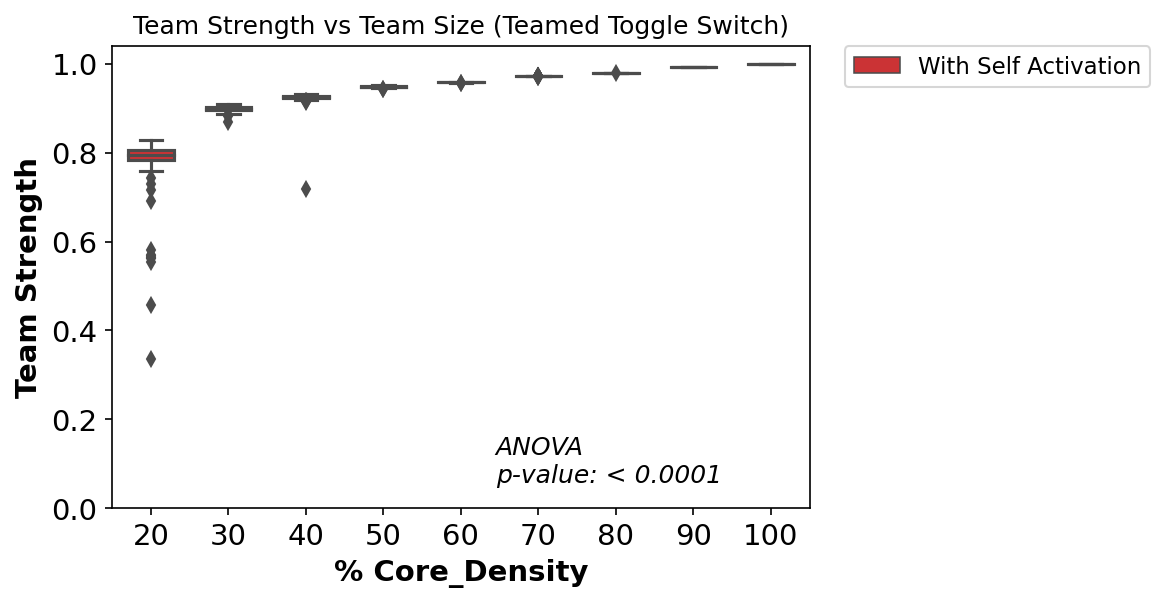

In [72]:
hue_plot_params = {
    'data': melt_table_complete,
    'x': "Core_Density",
    'y': "Team Strength",
}

import scipy.stats as stats

team_sizes = sorted(melt_table_complete['Core_Density'].unique())
f1_scores_by_team_size = [melt_table_complete[melt_table_complete['Core_Density'] == size]['Team Strength'].values for size in team_sizes]

# Perform one-way ANOVA
anova_result = stats.f_oneway(*f1_scores_by_team_size)
f_statistic = anova_result.statistic
hue_colors = sns.color_palette("Set1", len(melt_table_complete["Self Activation Status"].unique()))
plt.figure(figsize=(6, 4), dpi = 150)
plt.ylim(0, 1.04)
with sns.plotting_context("notebook"):

    ax = sns.boxplot(
        y="Team Strength",
        x="Core_Density",
        data=melt_table_complete,
        width=0.6,
        palette='Set1',
        color='red',
        hue= 'Self Activation Status')



    plt.title('Team Strength vs Team Size (Teamed Toggle Switch)')
    # plt.legend(bbox_to_anchor=(0.01, 0.2), loc='upper left', borderaxespad=0)
    plt.xlabel('% Core_Density', fontsize=14, fontweight='bold')
    plt.ylabel('Team Strength', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=14) 
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)




    # Display p-value on the plot
    if anova_result.pvalue < 0.0001:
        plt.text(0.55, 0.1, 'ANOVA \np-value: < 0.0001', ha='left', va='center',transform=ax.transAxes, fontdict={'style': 'italic'})
    else:
        plt.text(0.55, 0.1, f'ANOVA \np-value: {anova_result.pvalue:.4f}', ha='left', va='center',transform=ax.transAxes, fontdict={'style': 'italic'})


    plt.show()


In [85]:
pip install statsmodels

     |████████████████████████████████| 10.9 MB 10.4 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 11.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [86]:
import statsmodels.api as sm

In [144]:
# plt.figure(figsize=(6, 4), dpi = 150)
# sns.scatterplot(data=melt_table_complete, x="BiC A", y="F1 (Strict)", hue="Core_Density",s=20, palette='Set1')
# sns.lmplot(data=melt_table_complete, x="BiC A", y="F1 (Strict)", hue="Core_Density",palette='Set1')

# x = melt_table_complete["BiC A"]
# y = melt_table_complete["F1 (Strict)"]
# lowess = sm.nonparametric.lowess(y, x, frac=0.2)

# # Plot the line of best fit for the entire dataset
# plt.plot(lowess[:, 0], lowess[:, 1], color='black', linewidth=2)


# plt.title('F1 (Strict) vs BiC A (Teamed Toggle Switch)')
# plt.xlabel('BiC A', fontsize=14, fontweight='bold')
# plt.ylabel('F1 (Strict)', fontsize=14, fontweight='bold')
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14) 
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# from scipy.stats import spearmanr

# # Assuming 'BiC A' and 'F1 (Strict)' are columns in the melt DataFrame
# spearman_corr, p_value = spearmanr(melt["BiC A"], melt["F1 (Strict)"])
# print(p_value )
# print(f"Spearman correlation: {spearman_corr}")
# print(f"P-value: < 0.0001")
# plt.show()

5.837564400759969e-211


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

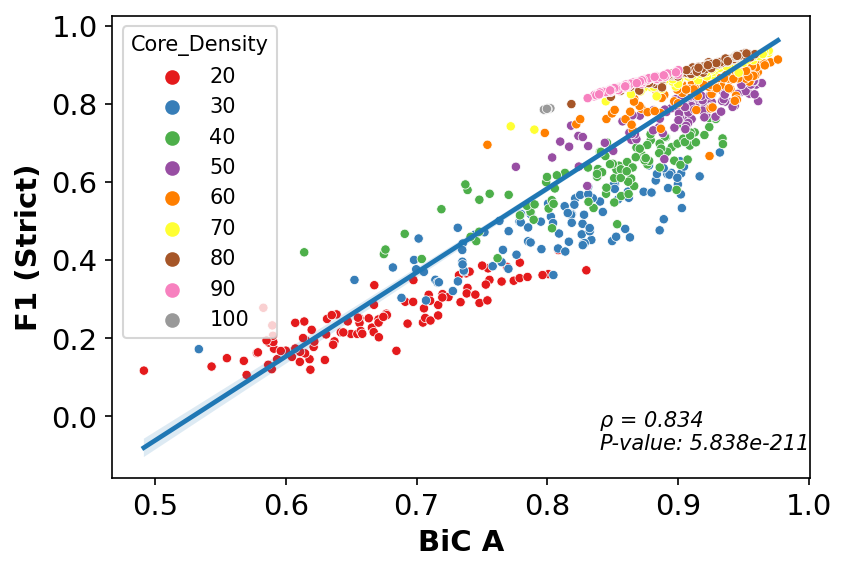

In [141]:
from scipy.stats import spearmanr

plt.figure(figsize=(6, 4), dpi = 150)
# Assuming 'BiC A' and 'F1 (Strict)' are columns in the melt DataFrame
spearman_corr, p_value = spearmanr(melt_table_complete["BiC A"], melt_table_complete["F1 (Strict)"])


sns.scatterplot(data=melt_table_complete, x="BiC A", y="F1 (Strict)", hue="Core_Density",s=20, palette='Set1')
sns.regplot(data=melt_table_complete, x="BiC A", y="F1 (Strict)", scatter=False, color='#1f77b4')

plt.text(0.7, 0.1, f'\u03C1 = {spearman_corr:.3f}\nP-value: {p_value:.3e}', 
         ha='left', va='center', transform=plt.gca().transAxes, fontdict={'style': 'italic'})
print(p_value )
plt.xlabel('BiC A', fontsize=14, fontweight='bold')
plt.ylabel('F1 (Strict)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)



<AxesSubplot: xlabel='Core_Density', ylabel='BiC A'>

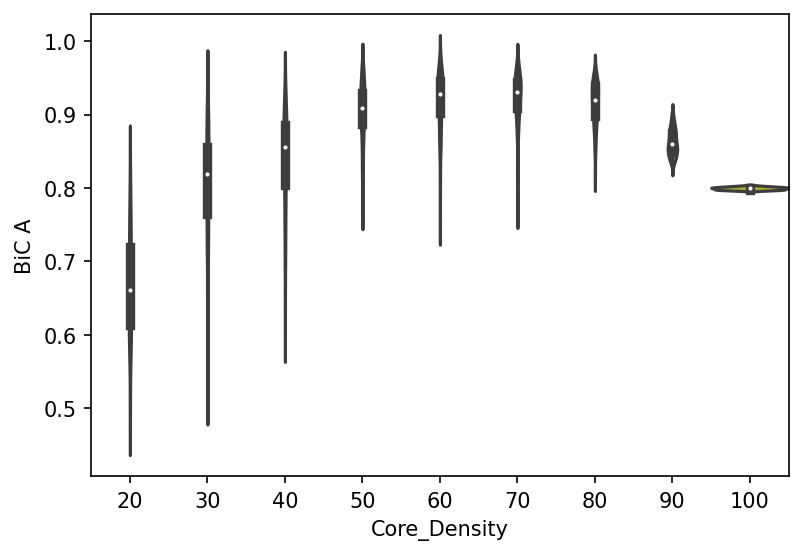

In [147]:
plt.figure(figsize=(6, 4), dpi = 150)
sns.violinplot(data=melt_table_complete, x="Core_Density", y="BiC A",width=1 )
# sns.violinplot(data=melt_table_complete[['BiC A', 'Core_Density']], inner="quartile")

Text(0.5, 1.0, 'F1 (Strict) vs Core Density (Teamed Toggle Switch)')

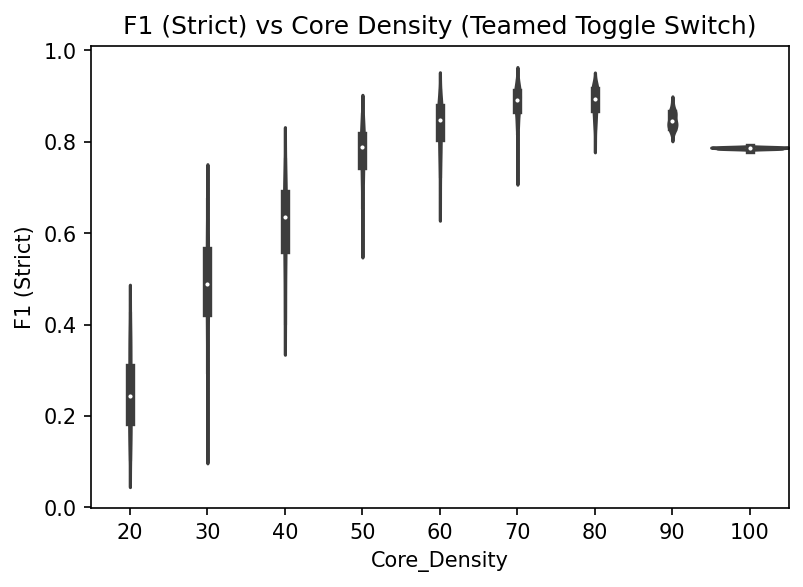

In [151]:
plt.figure(figsize=(6, 4), dpi = 150)
sns.violinplot(data=melt_table_complete, x="Core_Density", y="F1 (Strict)",width=1 )
plt.title('F1 (Strict) vs Core Density (Teamed Toggle Switch)')
# sns.violinplot(data=melt_table_complete[['BiC A', 'Core_Density']], inner="quartile")

Text(0.5, 1.0, 'BiC A vs Core Density (Teamed Toggle Switch)')

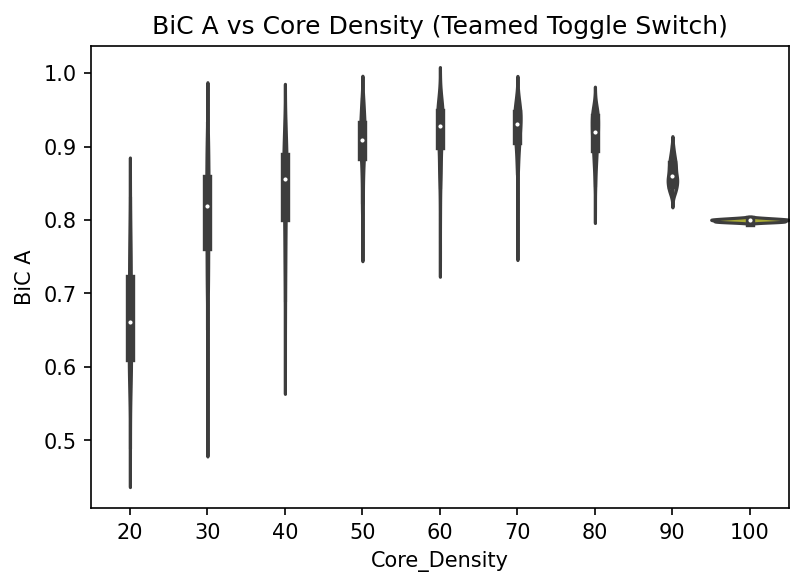

In [152]:
plt.figure(figsize=(6, 4), dpi = 150)
sns.violinplot(data=melt_table_complete, x="Core_Density", y="BiC A",width=1 )
plt.title('BiC A vs Core Density (Teamed Toggle Switch)')
# sns.violinplot(data=melt_table_complete[['BiC A', 'Core_Density']], inner="quartile")

In [ ]:
ax = corr_scatter(melt_table_complete, 'BiC A', 'F1 (Strict)', 'BiC A vs BiC B (Teamed Toggle Switch)')
plt.savefig('plots/BiC A vs BiC B.png', dpi = 300, bbox_inches='tight')

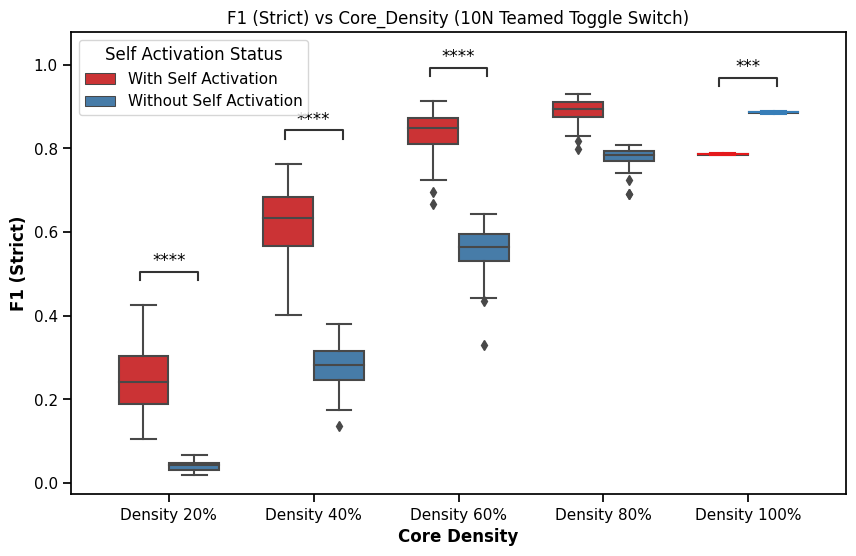

In [45]:
pairs = [
    [('Density 20%', 'Without Self Activation'), ('Density 20%', 'With Self Activation')],

    [('Density 40%','Without Self Activation'), ('Density 40%', 'With Self Activation')],


    [('Density 60%', 'Without Self Activation'), ('Density 60%','With Self Activation')],


    [('Density 100%', 'Without Self Activation'), ('Density 100%','With Self Activation')]



]

#sub_cat_order=['All Nodes','Core']
#cat_order  = ['60 Edges','90 Edges','120 Edges','150 Edges']
cat_order = ['Density 20%','Density 40%','Density 60%','Density 80%','Density 100%']
#hue_order = [2,4,6]
hue_plot_params = {
    'data':  melt_table_complete,
    'x': "Core_Density",
    'y': "F1_Individual_Nodes_Considered",
    "order": cat_order,
    "hue": "Self Activation Status"
    
}

plt.figure(figsize=(10, 6)) 
with sns.plotting_context("notebook"):
    # Create new plot
    ax = sns.boxplot(y="F1_Individual_Nodes_Considered", hue="Self Activation Status", x="Core_Density", data= melt_table_complete, width =0.7 ,
                     order = cat_order, palette = 'Set1')
    
    hue_colors = sns.color_palette("Set1", len(melt_table_complete["Self Activation Status"].unique()))
    for i, line in enumerate(ax.lines):
        box_index = i // 6
        if i//6 > 7:
            line.set_color(hue_colors[box_index % len(hue_colors)])

    # Plot with seaborn
    #ax = sns.boxplot(ax=ax, **hue_plot_params)

    # Add annotations
    annotator = Annotator(ax, pairs, **hue_plot_params)
    annotator.configure(test="Mann-Whitney", verbose=False)
    _, results = annotator.apply_and_annotate()
    plt.ylabel('F1 (Strict)', fontweight='bold')
    plt.xlabel('Core Density', fontweight='bold')

    # Label and show
    #add_legend(ax)
    #label_plot_for_states(ax)
    plt.title('F1 (Strict) vs Core_Density (10N Teamed Toggle Switch)')
    #plt.legend()
    #plt.legend(['2','4','6'],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    #plt.savefig('plots/F1 (Strict)_vs_Core_Density_TS_Team.png', bbox_inches='tight')
    plt.show()
    



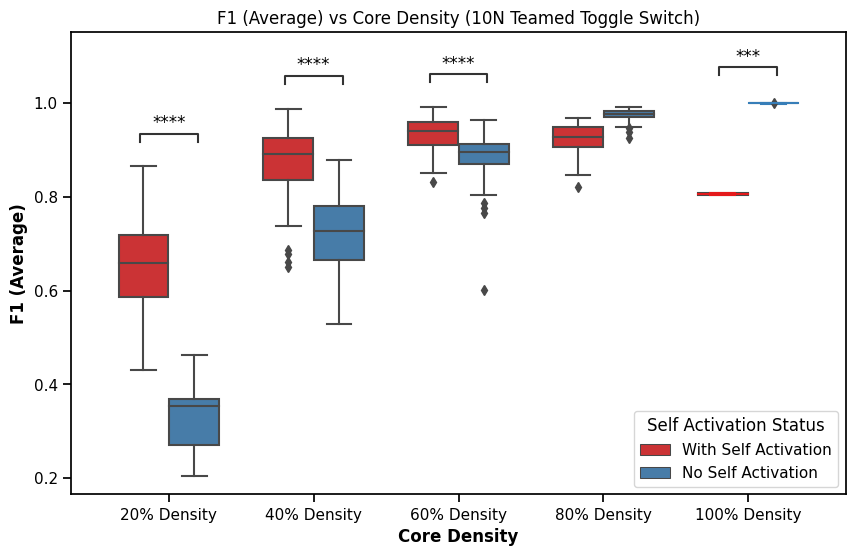

In [275]:
pairs = [
    [('20% Density', 'No Self Activation'), ('20% Density', 'With Self Activation')],

    [('40% Density','No Self Activation'), ('40% Density', 'With Self Activation')],


    [('60% Density', 'No Self Activation'), ('60% Density','With Self Activation')],


    [('100% Density', 'No Self Activation'), ('100% Density','With Self Activation')]



]

#sub_cat_order=['All Nodes','Core']
#cat_order  = ['60 Edges','90 Edges','120 Edges','150 Edges']
cat_order = ['20% Density','40% Density','60% Density','80% Density','100% Density']
#hue_order = [2,4,6]
hue_plot_params = {
    'data':  melt_table_complete,
    'x': "Core_Density",
    'y': "F1",
    "order": cat_order,
    "hue": "Self Activation Status"
    
}

plt.figure(figsize=(10, 6)) 
with sns.plotting_context("notebook"):
    # Create new plot
    ax = sns.boxplot(y="F1", hue="Self Activation Status", x="Core_Density", data= melt_table_complete, width =0.7 ,
                     order = cat_order, palette = 'Set1')
    
    hue_colors = sns.color_palette("Set1", len(melt_table_complete["Self Activation Status"].unique()))
    for i, line in enumerate(ax.lines):
        box_index = i // 6
        if i//6 > 7:
            line.set_color(hue_colors[box_index % len(hue_colors)])

    # Plot with seaborn
    #ax = sns.boxplot(ax=ax, **hue_plot_params)

    # Add annotations
    annotator = Annotator(ax, pairs, **hue_plot_params)
    annotator.configure(test="Mann-Whitney", verbose=False)
    _, results = annotator.apply_and_annotate()
    plt.ylabel('F1 (Average)', fontweight='bold')
    plt.xlabel('Core Density', fontweight='bold')

    # Label and show
    #add_legend(ax)
    #label_plot_for_states(ax)
    plt.title('F1 (Average) vs Core Density (10N Teamed Toggle Switch)')
    #plt.legend()
    #plt.legend(['2','4','6'],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.savefig('plots/F1 (Average)_vs_Core_Density_TS_Team.png', bbox_inches='tight')
    plt.show()
    



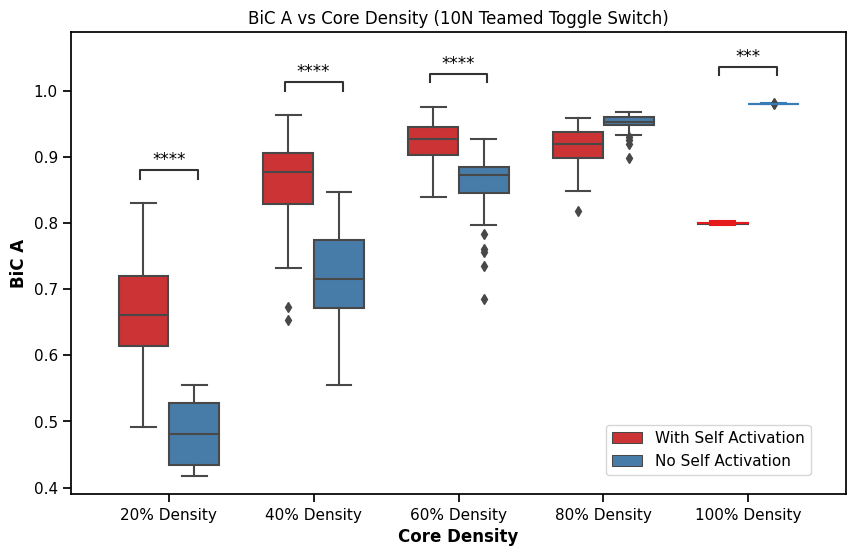

In [276]:
pairs = [
    [('20% Density', 'No Self Activation'), ('20% Density', 'With Self Activation')],

    [('40% Density','No Self Activation'), ('40% Density', 'With Self Activation')],


    [('60% Density', 'No Self Activation'), ('60% Density','With Self Activation')],


    [('100% Density', 'No Self Activation'), ('100% Density','With Self Activation')]



]

#sub_cat_order=['All Nodes','Core']
#cat_order  = ['60 Edges','90 Edges','120 Edges','150 Edges']
cat_order = ['20% Density','40% Density','60% Density','80% Density','100% Density']
#hue_order = [2,4,6]
hue_plot_params = {
    'data':  melt_table_complete,
    'x': "Core_Density",
    'y': "BiC A",
    "order": cat_order,
    "hue": "Self Activation Status"
    
}

plt.figure(figsize=(10, 6)) 
with sns.plotting_context("notebook"):
    # Create new plot
    ax = sns.boxplot(y="BiC A", hue="Self Activation Status", x="Core_Density", data= melt_table_complete, width =0.7 ,
                     order = cat_order, palette = 'Set1')
    
    hue_colors = sns.color_palette("Set1", len(melt_table_complete["Self Activation Status"].unique()))
    for i, line in enumerate(ax.lines):
        box_index = i // 6
        if i//6 > 7:
            line.set_color(hue_colors[box_index % len(hue_colors)])

    # Plot with seaborn
    #ax = sns.boxplot(ax=ax, **hue_plot_params)

    # Add annotations
    annotator = Annotator(ax, pairs, **hue_plot_params)
    annotator.configure(test="Mann-Whitney", verbose=False)
    _, results = annotator.apply_and_annotate()
    plt.ylabel('BiC A', fontweight='bold')
    plt.xlabel('Core Density', fontweight='bold')
    plt.legend(bbox_to_anchor=(0.69, 0.15), loc='upper left', borderaxespad=0)
    # Label and show
    #add_legend(ax)
    #label_plot_for_states(ax)
    plt.title('BiC A vs Core Density (10N Teamed Toggle Switch)')
    #plt.legend()
    #plt.legend(['2','4','6'],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.savefig('BiC A_vs_Core_Density_TS_Team.png', bbox_inches='tight')
    plt.show()
    



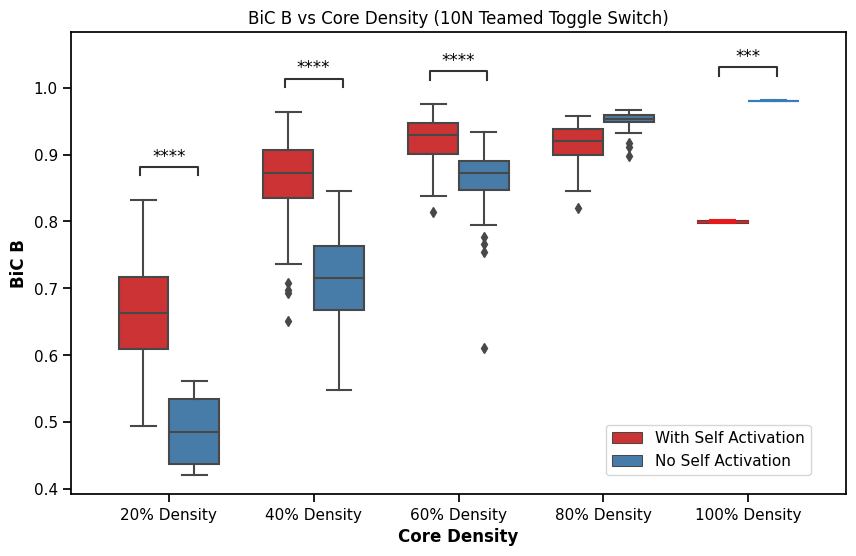

In [277]:
pairs = [
    [('20% Density', 'No Self Activation'), ('20% Density', 'With Self Activation')],

    [('40% Density','No Self Activation'), ('40% Density', 'With Self Activation')],


    [('60% Density', 'No Self Activation'), ('60% Density','With Self Activation')],


    [('100% Density', 'No Self Activation'), ('100% Density','With Self Activation')]



]

#sub_cat_order=['All Nodes','Core']
#cat_order  = ['60 Edges','90 Edges','120 Edges','150 Edges']
cat_order = ['20% Density','40% Density','60% Density','80% Density','100% Density']
#hue_order = [2,4,6]
hue_plot_params = {
    'data':  melt_table_complete,
    'x': "Core_Density",
    'y': "BiC B",
    "order": cat_order,
    "hue": "Self Activation Status"
    
}

plt.figure(figsize=(10, 6)) 
with sns.plotting_context("notebook"):
    # Create new plot
    ax = sns.boxplot(y="BiC B", hue="Self Activation Status", x="Core_Density", data= melt_table_complete, width =0.7 ,
                     order = cat_order, palette = 'Set1')
    
    hue_colors = sns.color_palette("Set1", len(melt_table_complete["Self Activation Status"].unique()))
    for i, line in enumerate(ax.lines):
        box_index = i // 6
        if i//6 > 7:
            line.set_color(hue_colors[box_index % len(hue_colors)])

    # Plot with seaborn
    #ax = sns.boxplot(ax=ax, **hue_plot_params)

    # Add annotations
    annotator = Annotator(ax, pairs, **hue_plot_params)
    annotator.configure(test="Mann-Whitney", verbose=False)
    _, results = annotator.apply_and_annotate()
    plt.ylabel('BiC B', fontweight='bold')
    plt.xlabel('Core Density', fontweight='bold')
    plt.legend(bbox_to_anchor=(0.69, 0.15), loc='upper left', borderaxespad=0)
    # Label and show
    #add_legend(ax)
    #label_plot_for_states(ax)
    plt.title('BiC B vs Core Density (10N Teamed Toggle Switch)')
    #plt.legend()
    #plt.legend(['2','4','6'],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.savefig('plots/BiC B_vs_Core_Density_TS_Team.png', bbox_inches='tight')
    plt.show()
    



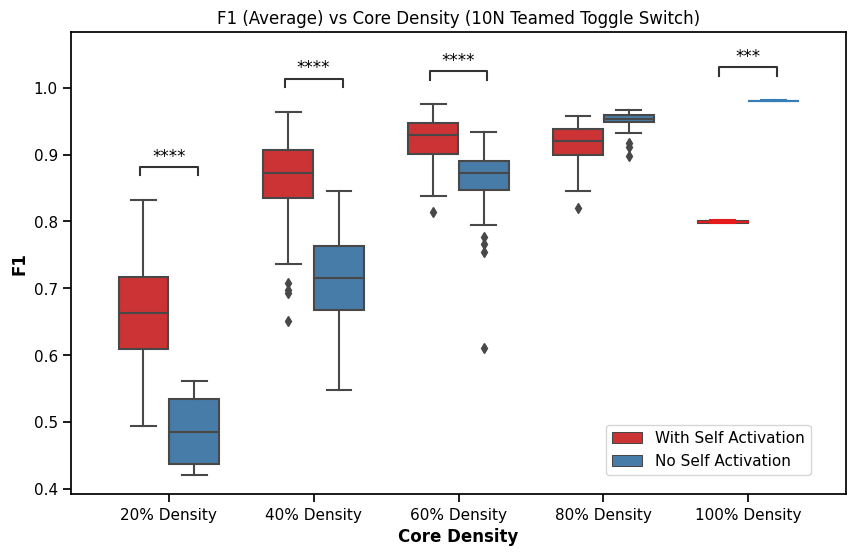

In [278]:
pairs = [
    [('20% Density', 'No Self Activation'), ('20% Density', 'With Self Activation')],

    [('40% Density','No Self Activation'), ('40% Density', 'With Self Activation')],


    [('60% Density', 'No Self Activation'), ('60% Density','With Self Activation')],


    [('100% Density', 'No Self Activation'), ('100% Density','With Self Activation')]



]

#sub_cat_order=['All Nodes','Core']
#cat_order  = ['60 Edges','90 Edges','120 Edges','150 Edges']
cat_order = ['20% Density','40% Density','60% Density','80% Density','100% Density']
#hue_order = [2,4,6]
hue_plot_params = {
    'data':  melt_table_complete,
    'x': "Core_Density",
    'y': "F1",
    "order": cat_order,
    "hue": "Self Activation Status"
    
}

plt.figure(figsize=(10, 6)) 
with sns.plotting_context("notebook"):
    # Create new plot
    ax = sns.boxplot(y="F1", hue="Self Activation Status", x="Core_Density", data= melt_table_complete, width =0.7 ,
                     order = cat_order, palette = 'Set1')
    
    hue_colors = sns.color_palette("Set1", len(melt_table_complete["Self Activation Status"].unique()))
    for i, line in enumerate(ax.lines):
        box_index = i // 6
        if i//6 > 7:
            line.set_color(hue_colors[box_index % len(hue_colors)])

    # Plot with seaborn
    #ax = sns.boxplot(ax=ax, **hue_plot_params)

    # Add annotations
    annotator = Annotator(ax, pairs, **hue_plot_params)
    annotator.configure(test="Mann-Whitney", verbose=False)
    _, results = annotator.apply_and_annotate()
    plt.ylabel('F1', fontweight='bold')
    plt.xlabel('Core Density', fontweight='bold')
    plt.legend(bbox_to_anchor=(0.69, 0.15), loc='upper left', borderaxespad=0)
    # Label and show
    #add_legend(ax)
    #label_plot_for_states(ax)
    plt.title('F1 (Average) vs Core Density (10N Teamed Toggle Switch)')
    #plt.legend()
    #plt.legend(['2','4','6'],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.savefig('plots/F1_vs_Core_Density_TS_Team.png', bbox_inches='tight')
    plt.show()
    



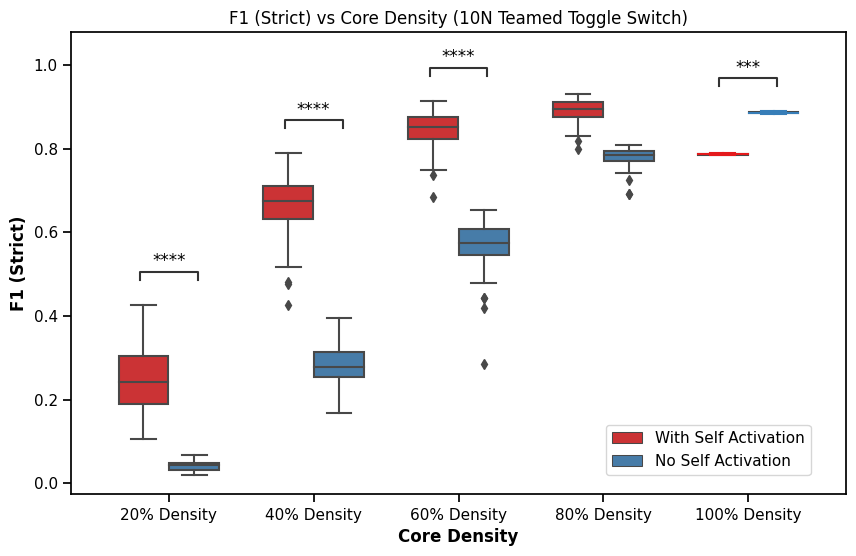

In [279]:
pairs = [
    [('20% Density', 'No Self Activation'), ('20% Density', 'With Self Activation')],

    [('40% Density','No Self Activation'), ('40% Density', 'With Self Activation')],


    [('60% Density', 'No Self Activation'), ('60% Density','With Self Activation')],


    [('100% Density', 'No Self Activation'), ('100% Density','With Self Activation')]



]

#sub_cat_order=['All Nodes','Core']
#cat_order  = ['60 Edges','90 Edges','120 Edges','150 Edges']
cat_order = ['20% Density','40% Density','60% Density','80% Density','100% Density']
#hue_order = [2,4,6]
hue_plot_params = {
    'data':  melt_table_complete,
    'x': "Core_Density",
    'y': "F1_Individual_Nodes_Considered",
    "order": cat_order,
    "hue": "Self Activation Status"
    
}

plt.figure(figsize=(10, 6)) 
with sns.plotting_context("notebook"):
    # Create new plot
    ax = sns.boxplot(y="F1_Individual_Nodes_Considered", hue="Self Activation Status", x="Core_Density", data= melt_table_complete, width =0.7 ,
                     order = cat_order, palette = 'Set1')
    
    hue_colors = sns.color_palette("Set1", len(melt_table_complete["Self Activation Status"].unique()))
    for i, line in enumerate(ax.lines):
        box_index = i // 6
        if i//6 > 7:
            line.set_color(hue_colors[box_index % len(hue_colors)])

    # Plot with seaborn
    #ax = sns.boxplot(ax=ax, **hue_plot_params)

    # Add annotations
    annotator = Annotator(ax, pairs, **hue_plot_params)
    annotator.configure(test="Mann-Whitney", verbose=False)
    _, results = annotator.apply_and_annotate()
    plt.ylabel('F1 (Strict)', fontweight='bold')
    plt.xlabel('Core Density', fontweight='bold')
    plt.legend(bbox_to_anchor=(0.69, 0.15), loc='upper left', borderaxespad=0)
    # Label and show
    #add_legend(ax)
    #label_plot_for_states(ax)
    plt.title('F1 (Strict) vs Core Density (10N Teamed Toggle Switch)')
    #plt.legend()
    #plt.legend(['2','4','6'],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.savefig('plots/F1_Individual_Nodes_Considered_vs_Core_Density_TS_Team.png', bbox_inches='tight')
    plt.show()
    



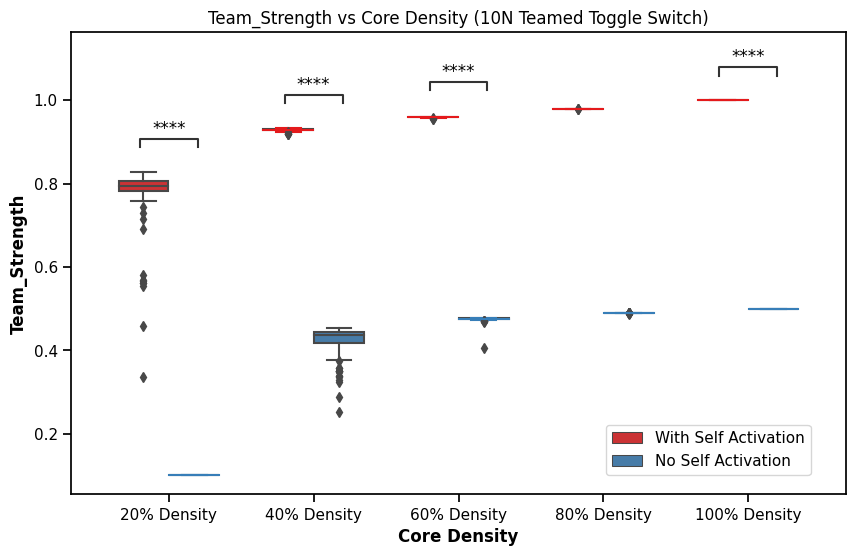

In [280]:
pairs = [
    [('20% Density', 'No Self Activation'), ('20% Density', 'With Self Activation')],

    [('40% Density','No Self Activation'), ('40% Density', 'With Self Activation')],


    [('60% Density', 'No Self Activation'), ('60% Density','With Self Activation')],


    [('100% Density', 'No Self Activation'), ('100% Density','With Self Activation')]



]

#sub_cat_order=['All Nodes','Core']
#cat_order  = ['60 Edges','90 Edges','120 Edges','150 Edges']
cat_order = ['20% Density','40% Density','60% Density','80% Density','100% Density']
#hue_order = [2,4,6]
hue_plot_params = {
    'data':  melt_table_complete,
    'x': "Core_Density",
    'y': "Team_Strength",
    "order": cat_order,
    "hue": "Self Activation Status"
    
}

plt.figure(figsize=(10, 6)) 
with sns.plotting_context("notebook"):
    # Create new plot
    ax = sns.boxplot(y="Team_Strength", hue="Self Activation Status", x="Core_Density", data= melt_table_complete, width =0.7 ,
                     order = cat_order, palette = 'Set1')
    
    hue_colors = sns.color_palette("Set1", len(melt_table_complete["Self Activation Status"].unique()))
    for i, line in enumerate(ax.lines):
        box_index = i // 6
        if i//6 not in [0,3]:
            line.set_color(hue_colors[box_index % len(hue_colors)])

    # Plot with seaborn
    #ax = sns.boxplot(ax=ax, **hue_plot_params)

    # Add annotations
    annotator = Annotator(ax, pairs, **hue_plot_params)
    annotator.configure(test="Mann-Whitney", verbose=False)
    _, results = annotator.apply_and_annotate()
    plt.ylabel('Team_Strength', fontweight='bold')
    plt.xlabel('Core Density', fontweight='bold')
    plt.legend(bbox_to_anchor=(0.69, 0.15), loc='upper left', borderaxespad=0)
    # Label and show
    #add_legend(ax)
    #label_plot_for_states(ax)
    plt.title('Team_Strength vs Core Density (10N Teamed Toggle Switch)')
    #plt.legend()
    #plt.legend(['2','4','6'],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.savefig('plots/Team_Strength_vs_Core_Density_TS_Team.png', bbox_inches='tight')
    plt.show()
    



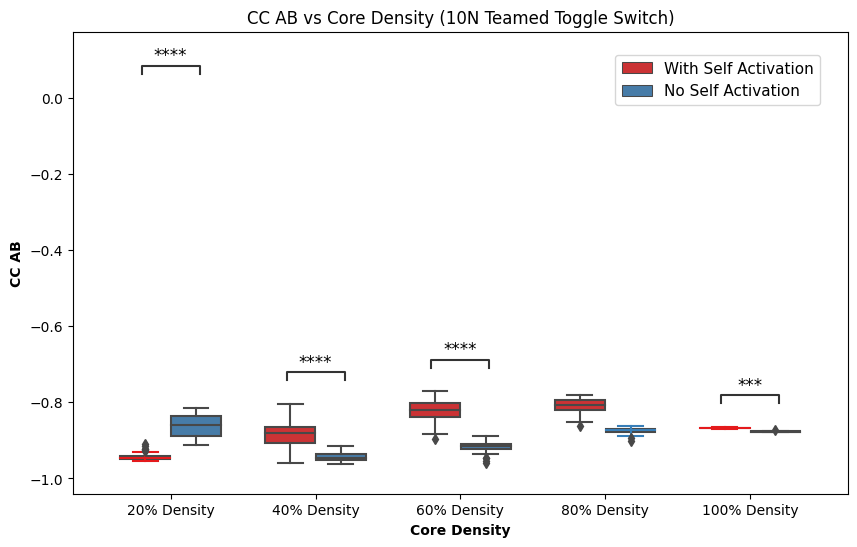

In [281]:
pairs = [
    [('20% Density', 'No Self Activation'), ('20% Density', 'With Self Activation')],

    [('40% Density','No Self Activation'), ('40% Density', 'With Self Activation')],


    [('60% Density', 'No Self Activation'), ('60% Density','With Self Activation')],


    [('100% Density', 'No Self Activation'), ('100% Density','With Self Activation')]



]

#sub_cat_order=['All Nodes','Core']
#cat_order  = ['60 Edges','90 Edges','120 Edges','150 Edges']
cat_order = ['20% Density','40% Density','60% Density','80% Density','100% Density']
#hue_order = [2,4,6]
hue_plot_params = {
    'data':  melt_table_complete,
    'x': "Core_Density",
    'y': "CC AB",
    "order": cat_order,
    "hue": "Self Activation Status"
    
}

plt.figure(figsize=(10, 6)) 
plt.ylim(-1.04,0)
with sns.plotting_context("notebook"):
    # Create new plot
    ax = sns.boxplot(y="CC AB", hue="Self Activation Status", x="Core_Density", data= melt_table_complete, width =0.7 ,
                     order = cat_order, palette = 'Set1')
    
    hue_colors = sns.color_palette("Set1", len(melt_table_complete["Self Activation Status"].unique()))
    for i, line in enumerate(ax.lines):
         box_index = i // 6
         if i//6 in [0,7,8]:
             line.set_color(hue_colors[box_index % len(hue_colors)])

    # Plot with seaborn
    #ax = sns.boxplot(ax=ax, **hue_plot_params)

    # Add annotations
    annotator = Annotator(ax, pairs, **hue_plot_params)
    annotator.configure(test="Mann-Whitney", verbose=False)
    _, results = annotator.apply_and_annotate()
    plt.ylabel('CC AB', fontweight='bold')
    plt.xlabel('Core Density', fontweight='bold')
    plt.legend(bbox_to_anchor=(0.7, 0.95), loc='upper left', borderaxespad=0)
    # Label and show
    #add_legend(ax)
    #label_plot_for_states(ax)
    plt.title('CC AB vs Core Density (10N Teamed Toggle Switch)')
    #plt.legend()
    #plt.legend(['2','4','6'],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.savefig('plots/CC AB_vs_Core_Density_TS_Team.png', bbox_inches='tight')
    plt.show()
    



In [258]:
# pairs = [
#     [('20% Density', 'No Self Activation'), ('20% Density', 'With Self Activation')],

#     [('40% Density','No Self Activation'), ('40% Density', 'With Self Activation')],


#     [('60% Density', 'No Self Activation'), ('60% Density','With Self Activation')],


#     [('100% Density', 'No Self Activation'), ('100% Density','With Self Activation')]



# ]

# #sub_cat_order=['All Nodes','Core']
# #cat_order  = ['60 Edges','90 Edges','120 Edges','150 Edges']
# cat_order = ['20% Density','40% Density','60% Density','100% Density']
# hue_order = [2,4,6]
# hue_plot_params = {
#     'data':  melt_table_complete,
#     'x': "Core_Density",
#     'y': "BiC A",
#     "order": cat_order,
#     "hue": "Self Activation Status"
    
# }

# plt.figure(figsize=(10, 6)) 
# with sns.plotting_context("notebook"):
#     # Create new plot
#     ax = sns.boxplot(y="BiC A", hue="Self Activation Status", x="Core_Density", data= melt_table_complete, width =0.7 )


#     # Plot with seaborn
#     #ax = sns.boxplot(ax=ax, **hue_plot_params)

#     # Add annotations
#     annotator = Annotator(ax, pairs, **hue_plot_params)
#     annotator.configure(test="Mann-Whitney", verbose=False)
#     _, results = annotator.apply_and_annotate()

#     # Label and show
#     #add_legend(ax)
#     #label_plot_for_states(ax)
#     plt.title('BiC A vs Core_Density (10N Teamed Toggle Switch)')
#     #plt.legend()
#     #plt.legend(['2','4','6'],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    
#     plt.savefig('BiC_A_vs_Core_Density_TS_Team.png', bbox_inches='tight')
#     plt.show()


In [259]:
# pairs = [
#     [('20% Density', 'No Self Activation'), ('20% Density', 'With Self Activation')],

#     [('40% Density','No Self Activation'), ('40% Density', 'With Self Activation')],


#     [('60% Density', 'No Self Activation'), ('60% Density','With Self Activation')],


#     [('100% Density', 'No Self Activation'), ('100% Density','With Self Activation')]



# ]

# #sub_cat_order=['All Nodes','Core']
# #cat_order  = ['60 Edges','90 Edges','120 Edges','150 Edges']
# cat_order = ['20% Density','40% Density','60% Density','100% Density']
# #hue_order = [2,4,6]
# hue_plot_params = {
#     'data':  melt_table_complete,
#     'x': "Core_Density",
#     'y': "BiC B",
#     "order": cat_order,
#     "hue": "Self Activation Status"
    
# }

# plt.figure(figsize=(10, 6)) 
# with sns.plotting_context("notebook"):
#     # Create new plot
#     ax = sns.boxplot(y="BiC B", hue="Self Activation Status", x="Core_Density", data= melt_table_complete, width =0.7 )


#     # Plot with seaborn
#     #ax = sns.boxplot(ax=ax, **hue_plot_params)

#     # Add annotations
#     annotator = Annotator(ax, pairs, **hue_plot_params)
#     annotator.configure(test="Mann-Whitney", verbose=False)
#     _, results = annotator.apply_and_annotate()

#     # Label and show
#     #add_legend(ax)
#     #label_plot_for_states(ax)
#     plt.title('BiC B vs Core_Density (10N Teamed Toggle Switch)')
#     #plt.legend()
#     #plt.legend(['2','4','6'],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    
#     plt.savefig('BiC_B_vs_Core_Density_TS_Team.png', bbox_inches='tight')
#     plt.show()


In [260]:
# pairs = [
#     [('20% Density', 'No Self Activation'), ('20% Density', 'With Self Activation')],

#     [('40% Density','No Self Activation'), ('40% Density', 'With Self Activation')],


#     [('60% Density', 'No Self Activation'), ('60% Density','With Self Activation')],


#     [('100% Density', 'No Self Activation'), ('100% Density','With Self Activation')]



# ]

# #sub_cat_order=['All Nodes','Core']
# #cat_order  = ['60 Edges','90 Edges','120 Edges','150 Edges']
# cat_order = ['20% Density','40% Density','60% Density','100% Density']
# hue_order = [2,4,6]
# hue_plot_params = {
#     'data':  melt_table_complete,
#     'x': "Core_Density",
#     'y': "CC AB",
#     "order": cat_order,
#     "hue": "Self Activation Status"
    
# }

# plt.figure(figsize=(10, 6)) 
# with sns.plotting_context("notebook"):
#     # Create new plot
#     ax = sns.boxplot(y="CC AB", hue="Self Activation Status", x="Core_Density", data= melt_table_complete, width =0.7 )


#     # Plot with seaborn
#     #ax = sns.boxplot(ax=ax, **hue_plot_params)

#     # Add annotations
#     annotator = Annotator(ax, pairs, **hue_plot_params)
#     annotator.configure(test="Mann-Whitney", verbose=False)
#     _, results = annotator.apply_and_annotate()

#     # Label and show
#     #add_legend(ax)
#     #label_plot_for_states(ax)
#     plt.title('CC AB vs Core_Density (10N Teamed Toggle Switch)')
#     #plt.legend()
#     #plt.legend(['2','4','6'],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

#     plt.savefig('CC_AB_vs_Core_Density_TS_Team.png', bbox_inches='tight')
#     plt.show()


In [261]:
# pairs = [
#     [('20% Density', 'No Self Activation'), ('20% Density', 'With Self Activation')],

#     [('40% Density','No Self Activation'), ('40% Density', 'With Self Activation')],


#     [('60% Density', 'No Self Activation'), ('60% Density','With Self Activation')],


#     [('100% Density', 'No Self Activation'), ('100% Density','With Self Activation')]



# ]

# #sub_cat_order=['All Nodes','Core']
# #cat_order  = ['60 Edges','90 Edges','120 Edges','150 Edges']
# cat_order = ['20% Density','40% Density','60% Density','100% Density']
# hue_order = [2,4,6]
# hue_plot_params = {
#     'data':  melt_table_complete,
#     'x': "Core_Density",
#     'y': "Team_Strength",
#     "order": cat_order,
#     "hue": "Self Activation Status"
    
# }

# plt.figure(figsize=(10, 6)) 
# with sns.plotting_context("notebook"):
#     # Create new plot
#     ax = sns.boxplot(y="Team_Strength", hue="Self Activation Status", x="Core_Density", data= melt_table_complete, width =0.7 )


#     # Plot with seaborn
#     #ax = sns.boxplot(ax=ax, **hue_plot_params)

#     # Add annotations
#     annotator = Annotator(ax, pairs, **hue_plot_params)
#     annotator.configure(test="Mann-Whitney", verbose=False)
#     _, results = annotator.apply_and_annotate()

#     # Label and show
#     #add_legend(ax)
#     #label_plot_for_states(ax)
#     plt.title('Team_Strength vs Core_Density (10N Teamed Toggle Switch)')
#     #plt.legend()
#     #plt.legend(['2','4','6'],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

#     plt.savefig('Team_Strength_vs_Core_Density_TS_Team.png', bbox_inches='tight')
#     plt.show()


In [262]:
# melt_table_complete = pd.read_csv('TT_data_unembedded_Jan1_Density_Varying.csv')

In [263]:
# pairs = [
#     [('20% Density', 'No Self Activation'), ('20% Density', 'With Self Activation')],

#     [('40% Density','No Self Activation'), ('40% Density', 'With Self Activation')],


#     [('60% Density', 'No Self Activation'), ('60% Density','With Self Activation')],


#     [('100% Density', 'No Self Activation'), ('100% Density','With Self Activation')]



# ]

# #sub_cat_order=['All Nodes','Core']
# #cat_order  = ['60 Edges','90 Edges','120 Edges','150 Edges']
# cat_order = ['20% Density','40% Density','60% Density','100% Density']
# hue_order = [2,4,6]
# hue_plot_params = {
#     'data':  melt_table_complete,
#     'x': "Core_Density",
#     'y': "Team_Strength",
#     "order": cat_order,
#     "hue": "Self Activation Status"
    
# }

# plt.figure(figsize=(10, 6)) 
# with sns.plotting_context("notebook"):
#     # Create new plot
#     ax = sns.boxplot(y="Team_Strength", hue="Self Activation Status", x="Core_Density", data= melt_table_complete, width =0.7 )


#     # Plot with seaborn
#     #ax = sns.boxplot(ax=ax, **hue_plot_params)

#     # Add annotations
#     annotator = Annotator(ax, pairs, **hue_plot_params)
#     annotator.configure(test="Mann-Whitney", verbose=False)
#     _, results = annotator.apply_and_annotate()

#     # Label and show
#     #add_legend(ax)
#     #label_plot_for_states(ax)
#     plt.title('Team_Strength vs Core_Density (10N Teamed Toggle Switch)')
#     #plt.legend()
#     #plt.legend(['2','4','6'],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

#     #plt.savefig('Team_Strength_vs_Core_Density_TS_Team.png', bbox_inches='tight')
#     plt.show()


In [264]:
# pairs = [
#     [('20% Density', 'No Self Activation'), ('20% Density', 'With Self Activation')],

#     [('40% Density','No Self Activation'), ('40% Density', 'With Self Activation')],


#     [('60% Density', 'No Self Activation'), ('60% Density','With Self Activation')],


#     [('100% Density', 'No Self Activation'), ('100% Density','With Self Activation')]



# ]

# cat_order = ['20% Density','40% Density','60% Density','100% Density']
# hue_order = [2,4,6]
# hue_plot_params = {
#     'data':  melt_table_complete,
#     'x': "Core_Density",
#     'y': "Team_Strength",
#     "order": cat_order,
#     "hue": "Self Activation Status"
    
# }

# plt.figure(figsize=(10, 6)) 
# with sns.plotting_context("notebook"):
#     # Create new plot
#     ax = sns.boxplot(y="Team_Strength", hue="Self Activation Status", x="Core_Density", data= melt_table_complete, width =0.7 )



#     annotator = Annotator(ax, pairs, **hue_plot_params)
#     annotator.configure(test="Mann-Whitney", verbose=False)
#     _, results = annotator.apply_and_annotate()


#     plt.title('Team_Strength vs Core_Density (10N Teamed Toggle Switch)')

#     plt.savefig('Team_Strength_vs_Core_Density_TS_Team.png', bbox_inches='tight')
#     plt.show()


In [265]:


def corr_scatter(data, x, y, title): 
    plt.figure(figsize=(8, 6))
    
    
    xlim = data.loc[:,x].min() 
    #print(xlim)
    ylim = data.loc[:,y].max() - data.loc[:,y].std()
    #print(ylim)

    sns.scatterplot(x=x, y=y, data=data, hue='Core_Density',style='Self Activation Status', markers=['o', 's'])
    sns.regplot(x=x, y=y, data=data, scatter=False, ci=None)


    #sns.lmplot(x=x, y=y, data=data, scatter_kws={"s": 6}, ci=None, scatter=False )
    
    per = stats.pearsonr(data[x], data[y])
    plt.title(title) 
    plt.text(xlim, ylim, 'Pearson corr {} \np_value {}'.format(round(per[0],3),'< 10e-04'), horizontalalignment='left', size='large', color='black')
    plt.legend(loc='lower right')
    if x == 'PEBP1':
        plt.xlabel('RKIP')
    if y == 'PEBP1':
        plt.ylabel('RKIP')

    #plt.show()



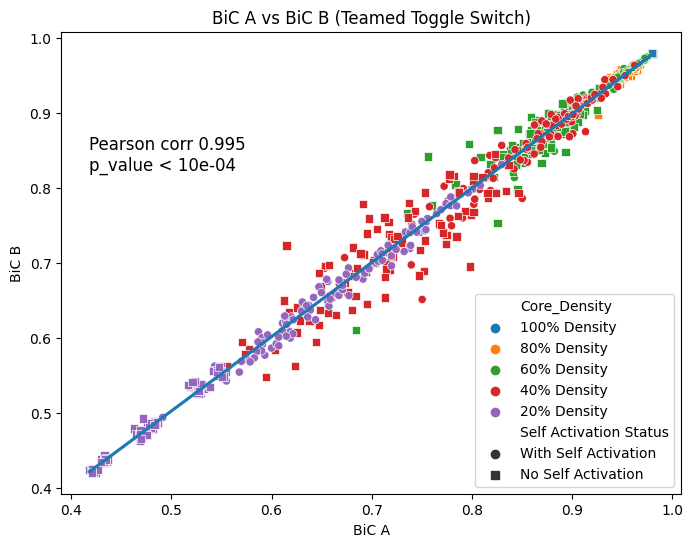

In [266]:
ax = corr_scatter(melt_table_complete, 'BiC A', 'BiC B', 'BiC A vs BiC B (Teamed Toggle Switch)')
plt.savefig('plots/BiC A vs BiC B.png', dpi = 300, bbox_inches='tight')

In [98]:
# sef_act_list = ['With Self Activation','No Self Activation']
# core_density_list = ['20% Density','40% Density','60% Density','80% Density','100% Density']

In [216]:
# sef_act_list = ['With Self Activation','No Self Activation']
# core_density_list = ['20% Density','40% Density','60% Density','80% Density','100% Density']

# melt_table_complete[ (melt_table_complete['Core_Density'] == '20% Density') & 
#                     ( melt_table_complete['Self Activation Status'] == 'No Self Activation')]

In [48]:
melt_table_complete

,Unnamed: 0,index,Type,Core_Density,Peripheral_Nodes,Peripheral_Edges,BiC A,BiC B,CC AB,F1,F1_Individual_Nodes_Considered,Team_Strength,in_degree_Team_A,in_degree_Team_B,Number_of_Self_Activations,indegree,Self Activation Status,Average Indegree Per Core Node
0,0,20% Density_10 Nodes_0 Edges_0,Lowered Density,20% Density,10 Nodes,0 Edges,0.647340,0.668579,-0.950908,0,0.205618,0.802,0,0,0,NaN,With Self Activation,4.0
1,1,20% Density_10 Nodes_0 Edges_1,Lowered Density,20% Density,10 Nodes,0 Edges,0.705669,0.711769,-0.946493,0,0.234448,0.826,0,0,0,NaN,With Self Activation,4.0
2,2,20% Density_10 Nodes_0 Edges_2,Lowered Density,20% Density,10 Nodes,0 Edges,0.656287,0.675676,-0.949461,0,0.209987,0.789,0,0,0,NaN,With Self Activation,4.0
3,3,20% Density_10 Nodes_0 Edges_3,Lowered Density,20% Density,10 Nodes,0 Edges,0.649820,0.661150,-0.952077,0,0.183861,0.769,0,0,0,NaN,With Self Activation,4.0
4,4,20% Density_10 Nodes_0 Edges_4,Lowered Density,20% Density,10 Nodes,0 Edges,0.569963,0.569269,-0.941426,0,0.094516,0.563,0,0,0,NaN,With Self Activation,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,5,100% Density_10 Nodes_0 Edges_5,Lowered Density,100% Density,10 Nodes,0 Edges,0.980487,0.980361,-0.877207,0,0.499076,0.500,0,0,0,NaN,No Self Activation,4.0
816,6,100% Density_10 Nodes_0 Edges_6,Lowered Density,100% Density,10 Nodes,0 Edges,0.980409,0.980594,-0.877826,0,0.498851,0.500,0,0,0,NaN,No Self Activation,4.0
817,7,100% Density_10 Nodes_0 Edges_7,Lowered Density,100% Density,10 Nodes,0 Edges,0.980601,0.980782,-0.876809,0,0.499076,0.500,0,0,0,NaN,No Self Activation,4.0
818,8,100% Density_10 Nodes_0 Edges_8,Lowered Density,100% Density,10 Nodes,0 Edges,0.980432,0.980056,-0.875527,0,0.499126,0.500,0,0,0,NaN,No Self Activation,4.0


In [63]:
import pandas as pd


sef_act_list = ['With Self Activation', 'No Self Activation']
core_density_list = ['20% Density', '40% Density', '60% Density', '80% Density', '100% Density']

# Initialize an empty DataFrame to store Fano factors
fano_factors_df = pd.DataFrame(columns=['Self Activation Status', 'Core Density', 'Fano Factor','Variance','Mean Absolute Deviation', 
                                        'Range','Co efficient of Variation'])

# Iterate through each combination of 'Self Activation Status' and 'Core Density'
for sef_act in sef_act_list:
    for core_density in core_density_list:
        # Filter the DataFrame based on the current combination
        subset_df = melt_table_complete[
            (melt_table_complete['Core_Density'] == core_density) &
            (melt_table_complete['Self Activation Status'] == sef_act)
        ]

        # Calculate the mean and variance for each column
        for col in ['BiC A', 'BiC B', 'CC AB','F1','F1_Individual_Nodes_Considered','Team_Strength']:
            mean_col = subset_df[col].mean()
            variance_col = subset_df[col].var()
            std_col = subset_df[col].std()
            coefficient_of_variation = (std_col / mean_col) * 100
            range = subset_df[col].max() - subset_df[col].min()
            fano_factor_col = variance_col / mean_col
            mean_absolute_variation = subset_df[col].mad()


            # Append the result to the DataFrame
            fano_factors_df = fano_factors_df.append({
                'Self Activation Status': sef_act,
                'Core Density': core_density,
                'Column': col,
                'Fano Factor': fano_factor_col,
                'Variance': variance_col,
                'Mean': mean_col,
                'Co efficient of Variation': np.abs(coefficient_of_variation),
                'Range': range,
                'Mean Absolute Deviation': mean_absolute_variation
            }, ignore_index=True)

# Print the resulting DataFrame
print(fano_factors_df)


   Self Activation Status  Core Density   Fano Factor      Variance  \
0    With Self Activation   20% Density  7.166672e-03  4.785600e-03   
1    With Self Activation   20% Density  7.160188e-03  4.777881e-03   
2    With Self Activation   20% Density -7.288089e-05  6.877698e-05   
3    With Self Activation   20% Density  1.155224e-02  7.589924e-03   
4    With Self Activation   20% Density  2.420137e-02  5.988379e-03   
5    With Self Activation   20% Density  8.240087e-03  6.365303e-03   
6    With Self Activation   40% Density  4.262343e-03  3.676999e-03   
7    With Self Activation   40% Density  4.545811e-03  3.913906e-03   
8    With Self Activation   40% Density -1.155152e-03  1.022680e-03   
9    With Self Activation   40% Density  6.013072e-03  5.239569e-03   
10   With Self Activation   40% Density  7.422090e-03  4.918798e-03   
11   With Self Activation   40% Density  8.964277e-06  8.328889e-06   
12   With Self Activation   60% Density  9.815928e-04  9.060829e-04   
13   W

/tmp/ipykernel_113526/3769028549.py:28: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mean_absolute_variation = subset_df[col].mad()
/tmp/ipykernel_113526/3769028549.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fano_factors_df = fano_factors_df.append({
/tmp/ipykernel_113526/3769028549.py:28: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mean_absolute_variation = subset_df[col].mad()
/tmp/ipykernel_113526/3769028549.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fano_factors_df = fano_factors_df.append({
/tmp/ipykernel_113526/3769028549.py:28: FutureWarning: The 'mad' met

In [219]:
# import pandas as pd


# sef_act_list = ['With Self Activation', 'No Self Activation']
# core_density_list = ['20% Density', '40% Density', '60% Density', '80% Density', '100% Density']

# # Initialize an empty DataFrame to store Fano factors
# fano_factors_df = pd.DataFrame(columns=['Self Activation Status', 'Core Density', 'Fano Factor','Variance'])

# # Iterate through each combination of 'Self Activation Status' and 'Core Density'
# for sef_act in sef_act_list:
#     for core_density in core_density_list:
#         # Filter the DataFrame based on the current combination
#         subset_df = melt_table_complete[
#             (melt_table_complete['Core_Density'] == core_density) &
#             (melt_table_complete['Self Activation Status'] == sef_act)
#         ]

#         # Calculate the mean and variance for each column
#         for col in ['BiC A', 'BiC B', 'CC AB']:
#             mean_col = subset_df[col].mean()
#             variance_col = subset_df[col].var()
#             std_col = subset_df[col].std()
#             coefficient_of_variation = (std_col / mean_col) * 100


#             # Calculate the Fano factor for each column
#             fano_factor_col = variance_col / mean_col

#             # Append the result to the DataFrame
#             fano_factors_df = fano_factors_df.append({
#                 'Self Activation Status': sef_act,
#                 'Core Density': core_density,
#                 'Column': col,
#                 'Fano Factor': fano_factor_col,
#                 'Variance': variance_col,
#                 'Mean': mean_col,
#                 'Co efficient of Variation': coefficient_of_variation
#             }, ignore_index=True)

# # Print the resulting DataFrame
# print(fano_factors_df)


In [220]:
# fano_factors_df

In [49]:
melt_table_complete = pd.read_csv('TT_data_unembedded_Jan14_Density_Varying_Figure2.csv')

In [61]:
melt_table_complete

,Unnamed: 0,index,Type,Core_Density,Peripheral_Nodes,Peripheral_Edges,BiC A,BiC B,CC AB,F1,F1_Individual_Nodes_Considered,Team_Strength,in_degree_Team_A,in_degree_Team_B,Number_of_Self_Activations,indegree,Self Activation Status,Team Size
0,0,0Indegree100% Density_0 Nodes_0 Edges_0,Lowered Density,100% Density,0 Nodes,0,0.800114,0.800108,-0.869002,0.806159,0.787255,1.0,NaN,NaN,0,0,With Self Activation,5.0
1,1,0Indegree100% Density_0 Nodes_0 Edges_1,Lowered Density,100% Density,0 Nodes,0,0.798260,0.798454,-0.866904,0.804376,0.784106,1.0,NaN,NaN,0,0,With Self Activation,5.0
2,2,0Indegree100% Density_0 Nodes_0 Edges_2,Lowered Density,100% Density,0 Nodes,0,0.797470,0.797640,-0.867977,0.803439,0.785080,1.0,NaN,NaN,0,0,With Self Activation,5.0
3,3,0Indegree100% Density_0 Nodes_0 Edges_3,Lowered Density,100% Density,0 Nodes,0,0.801720,0.801705,-0.865916,0.807689,0.786932,1.0,NaN,NaN,0,0,With Self Activation,5.0
4,4,0Indegree100% Density_0 Nodes_0 Edges_4,Lowered Density,100% Density,0 Nodes,0,0.800593,0.800657,-0.866715,0.806972,0.788452,1.0,NaN,NaN,0,0,With Self Activation,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,95,0Indegree20% Density_0 Nodes_0 Edges_95,Lowered Density,20% Density,0 Nodes,0,0.527796,0.529668,-0.887091,0.365110,0.045429,0.1,NaN,NaN,0,0,No Self Activation,5.0
816,96,0Indegree20% Density_0 Nodes_0 Edges_96,Lowered Density,20% Density,0 Nodes,0,0.434144,0.438204,-0.836473,0.267628,0.032463,0.1,NaN,NaN,0,0,No Self Activation,5.0
817,97,0Indegree20% Density_0 Nodes_0 Edges_97,Lowered Density,20% Density,0 Nodes,0,0.429888,0.435212,-0.830910,0.263818,0.032292,0.1,NaN,NaN,0,0,No Self Activation,5.0
818,98,0Indegree20% Density_0 Nodes_0 Edges_98,Lowered Density,20% Density,0 Nodes,0,0.523383,0.542736,-0.885051,0.374359,0.043109,0.1,NaN,NaN,0,0,No Self Activation,5.0


In [234]:
# import seaborn as sns
# import matplotlib.pyplot as plt




# sns.lineplot(x='Core Density', y='Mean Absolute Deviation', hue='Self Activation Status', style='Column', data=fano_factors_df[fano_factors_df['Column'] == 'CC AB'], palette='viridis')

# # Add scatterplot points with 'x' markers
# sns.scatterplot(x='Core Density', y='Mean Absolute Deviation', hue='Self Activation Status', legend=False, style='Column', markers=['o'], s=100, data=fano_factors_df[fano_factors_df['Column'] == 'CC AB'], 
#                 palette='viridis')

# plt.xlabel('Core Density')
# plt.ylabel('Mean Absolute Deviation')
# plt.title(' Mean Absolute Deviation (CC AB) by Core Density (Teamed Toggle Switch)')

# # Show the legend
# #plt.legend(['Self Activation Status','d'])

# # Show the plot
# plt.savefig('plots/Mean Absolute Deviation CC AB vs Core Density.png', dpi = 300, bbox_inches='tight')


In [64]:
def variation_plotter(network_metric,variation_metric):
    sns.lineplot(x='Core Density', y=variation_metric, hue='Self Activation Status', style='Column', 
                data=fano_factors_df[fano_factors_df['Column'] == network_metric], palette='viridis')

    # Add scatterplot points with 'x' markers
    sns.scatterplot(x='Core Density', y=variation_metric, hue='Self Activation Status', legend=False,
                    style='Column', markers=['o'], s=100, data=fano_factors_df[fano_factors_df['Column'] == network_metric], 
                    palette='viridis')

    plt.xlabel('Core Density')
    # plt.ylabel(variation_metric)
    # plt.title(variation_metric +'('+network_metric+') by Core Density (Teamed Toggle Switch)')
    if network_metric == 'F1':
         plt.ylabel(variation_metric +' F1 (Average)')
         plt.title('F1 (Average)'+'('+network_metric+') by Core Density (Teamed Toggle Switch)')
    elif network_metric == 'F1_Individual_Nodes_Considered':
        plt.ylabel(variation_metric +' F1 (Strict)')
        plt.title('F1 (Strict)'+'('+variation_metric+') by Core Density (Teamed Toggle Switch)')

    else:
        plt.ylabel(variation_metric + ' '+network_metric)
        plt.title(network_metric+'('+variation_metric+') by Core Density (Teamed Toggle Switch)')


    # Show the plot
    plt.savefig('plots/variation_plots_supp/'+variation_metric+'_'+network_metric+ ' vs Core Density.png', dpi = 300, bbox_inches='tight')
    plt.clf()


In [65]:
fano_factors_df

,Self Activation Status,Core Density,Fano Factor,Variance,Mean Absolute Deviation,Range,Co efficient of Variation,Column,Mean
0,With Self Activation,20% Density,7.166672e-03,4.785600e-03,5.744238e-02,3.385972e-01,1.035975e+01,BiC A,0.667758
1,With Self Activation,20% Density,7.160188e-03,4.777881e-03,5.711808e-02,3.371737e-01,1.035874e+01,BiC B,0.667284
2,With Self Activation,20% Density,-7.288089e-05,6.877698e-05,6.153013e-03,4.437570e-02,8.788042e-01,CC AB,-0.943690
3,With Self Activation,20% Density,1.155224e-02,7.589924e-03,7.187234e-02,4.327814e-01,1.326012e+01,F1,0.657009
4,With Self Activation,20% Density,2.420137e-02,5.988379e-03,6.379150e-02,3.194734e-01,3.127414e+01,F1_Individual_Nodes_Considered,0.247440
5,With Self Activation,20% Density,8.240087e-03,6.365303e-03,4.447360e-02,4.920000e-01,1.032814e+01,Team_Strength,0.772480
6,With Self Activation,40% Density,4.262343e-03,3.676999e-03,4.706282e-02,3.095497e-01,7.029130e+00,BiC A,0.862671
7,With Self Activation,40% Density,4.545811e-03,3.913906e-03,4.882397e-02,3.120958e-01,7.266180e+00,BiC B,0.860992
8,With Self Activation,40% Density,-1.155152e-03,1.022680e-03,2.580824e-02,1.546056e-01,3.612179e+00,CC AB,-0.885321
9,With Self Activation,40% Density,6.013072e-03,5.239569e-03,5.648201e-02,3.365009e-01,8.307084e+00,F1,0.871363


In [66]:
variation_plotter('BiC B','Range')
variation_plotter('BiC B','Fano Factor')
variation_plotter('BiC B','Mean Absolute Deviation')
variation_plotter('BiC B','Co efficient of Variation')
variation_plotter('BiC B','Variance')

<Figure size 640x480 with 0 Axes>

In [67]:
variation_plotter('F1','Range')
variation_plotter('F1','Fano Factor')
variation_plotter('F1','Mean Absolute Deviation')
variation_plotter('F1','Co efficient of Variation')
variation_plotter('F1','Variance')

<Figure size 640x480 with 0 Axes>

In [68]:
variation_plotter('BiC A','Range')
variation_plotter('BiC A','Fano Factor')
variation_plotter('BiC A','Mean Absolute Deviation')
variation_plotter('BiC A','Co efficient of Variation')
variation_plotter('BiC A','Variance')

<Figure size 640x480 with 0 Axes>

In [69]:
variation_plotter('CC AB','Range')
variation_plotter('CC AB','Fano Factor')
variation_plotter('CC AB','Mean Absolute Deviation')
variation_plotter('CC AB','Co efficient of Variation')
variation_plotter('CC AB','Variance')

<Figure size 640x480 with 0 Axes>

In [70]:
variation_plotter('Team_Strength','Range')
variation_plotter('Team_Strength','Fano Factor')
variation_plotter('Team_Strength','Mean Absolute Deviation')
variation_plotter('Team_Strength','Co efficient of Variation')
variation_plotter('Team_Strength','Variance')

<Figure size 640x480 with 0 Axes>

In [74]:
variation_plotter('F1_Individual_Nodes_Considered','Range')
variation_plotter('F1_Individual_Nodes_Considered','Fano Factor')
variation_plotter('F1_Individual_Nodes_Considered','Mean Absolute Deviation')
variation_plotter('F1_Individual_Nodes_Considered','Co efficient of Variation')
variation_plotter('F1_Individual_Nodes_Considered','Variance')

<Figure size 640x480 with 0 Axes>

In [72]:
fano_factors_df.to_csv('plots/variation_plots_supp/variance_metrics_core_density_vary.csv')

In [35]:
melt_table_complete = pd.read_csv('TT_data_unembedded_Feb6_Density_Varying_Figure2.csv')
melt_table_complete 

,Unnamed: 0,index,Type,Core_Density,Peripheral_Nodes,Peripheral_Edges,BiC A,BiC B,CC AB,F1,F1_Individual_Nodes_Considered,Team_Strength,in_degree_Team_A,in_degree_Team_B,Number_of_Self_Activations,indegree,Self Activation Status,Team Size
0,0,Density 20%_With Self Activation_Network_0,Lowered Density,Density 20%,0 Nodes,0,0.647340,0.668579,-0.950908,0.652045,0.242943,0.802,0,0,0,0,With Self Activation,5.0
1,1,Density 20%_With Self Activation_Network_1,Lowered Density,Density 20%,0 Nodes,0,0.705669,0.711769,-0.946493,0.721913,0.276346,0.826,0,0,0,0,With Self Activation,5.0
2,2,Density 20%_With Self Activation_Network_2,Lowered Density,Density 20%,0 Nodes,0,0.656287,0.675676,-0.949461,0.667113,0.251189,0.789,0,0,0,0,With Self Activation,5.0
3,3,Density 20%_With Self Activation_Network_3,Lowered Density,Density 20%,0 Nodes,0,0.649820,0.661150,-0.952077,0.666360,0.210834,0.769,0,0,0,0,With Self Activation,5.0
4,4,Density 20%_With Self Activation_Network_4,Lowered Density,Density 20%,0 Nodes,0,0.569963,0.569269,-0.941426,0.543474,0.106023,0.563,0,0,0,0,With Self Activation,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,5,Density 100%_Without Self Activation_Network_5,Lowered Density,Density 100%,0 Nodes,0,0.980487,0.980361,-0.877207,0.998702,0.883845,0.500,0,0,0,0,Without Self Activation,5.0
816,6,Density 100%_Without Self Activation_Network_6,Lowered Density,Density 100%,0 Nodes,0,0.980409,0.980594,-0.877826,0.998801,0.886336,0.500,0,0,0,0,Without Self Activation,5.0
817,7,Density 100%_Without Self Activation_Network_7,Lowered Density,Density 100%,0 Nodes,0,0.980601,0.980782,-0.876809,0.998851,0.883922,0.500,0,0,0,0,Without Self Activation,5.0
818,8,Density 100%_Without Self Activation_Network_8,Lowered Density,Density 100%,0 Nodes,0,0.980432,0.980056,-0.875527,0.998851,0.882846,0.500,0,0,0,0,Without Self Activation,5.0


0     0.242943
1     0.276346
2     0.251189
3     0.210834
4     0.106023
        ...   
95    0.239319
96    0.254515
97    0.356676
98    0.385712
99    0.200381
Name: F1_Individual_Nodes_Considered, Length: 100, dtype: float64

F-statistic: 1587.4929901357375
P-value: 6.204716759056842e-246


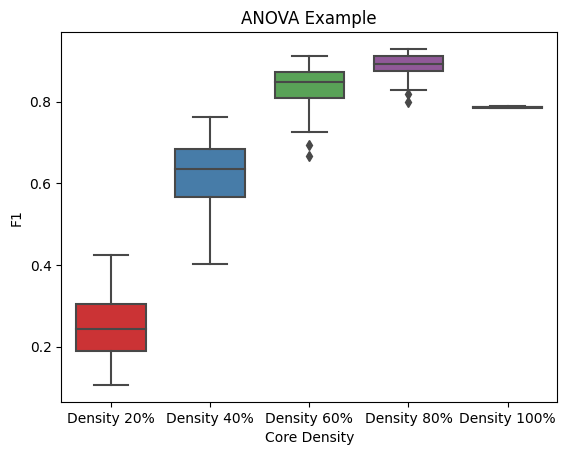

In [54]:
import numpy as np
from scipy.stats import f_oneway
import matplotlib.pyplot as plt

# Generate example data
np.random.seed(42)  # For reproducibility
core_density_20 = melt_table_complete[(melt_table_complete['Self Activation Status']=='With Self Activation') &
                                       (melt_table_complete['Core_Density'] == 'Density 20%')].loc[:,'F1_Individual_Nodes_Considered']

core_density_40 = melt_table_complete[(melt_table_complete['Self Activation Status']=='With Self Activation') &
                                        (melt_table_complete['Core_Density'] == 'Density 40%')].loc[:,'F1_Individual_Nodes_Considered']

core_density_60 = melt_table_complete[(melt_table_complete['Self Activation Status']=='With Self Activation') &
                                        (melt_table_complete['Core_Density'] == 'Density 60%')].loc[:,'F1_Individual_Nodes_Considered']

core_density_80 = melt_table_complete[(melt_table_complete['Self Activation Status']=='With Self Activation') &
                                        (melt_table_complete['Core_Density'] == 'Density 80%')].loc[:,'F1_Individual_Nodes_Considered']

core_density_100 = melt_table_complete[(melt_table_complete['Self Activation Status']=='With Self Activation') &
                                        (melt_table_complete['Core_Density'] == 'Density 100%')].loc[:,'F1_Individual_Nodes_Considered']
                                        



# Combine the data
data = [core_density_20, core_density_40, core_density_60, core_density_80, core_density_100]

# Perform one-way ANOVA
f_statistic, p_value = f_oneway(*data)

# Print results
print("F-statistic:", f_statistic)
print("P-value:", p_value)

# Plot the data
sns.boxplot(y="F1_Individual_Nodes_Considered",  x="Core_Density", data= melt_table_complete[(melt_table_complete['Self Activation Status']=='With Self Activation')], width =0.7 ,
                      palette = 'Set1')
plt.xlabel('Core Density')
plt.ylabel('F1')
plt.title('ANOVA Example')
plt.show()


In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chisquare

# Example data
core_density = np.array([20, 40, 60, 80, 100])
response = np.array([core_density_1, core_density_2, core_density_3, core_density_4, core_density_5])

# Flatten the response array for curve fitting
response_flat = response.flatten()

# Define a quadratic function
def quadratic_function(x, a, b, c):
    return a * x**2 + b * x + c

# Fit the curve
params, covariance = curve_fit(quadratic_function, core_density, response_flat)

# Extract fitted parameters
a, b, c = params

# Predicted values using the fitted curve
predicted_values = quadratic_function(core_density, a, b, c)

# Calculate R-squared
ss_total = np.sum((response_flat - np.mean(response_flat))**2)
ss_residual = np.sum((response_flat - quadratic_function(core_density, a, b, c))**2)
r_squared = 1 - (ss_residual / ss_total)

# Plot the data and fitted curve
plt.scatter(core_density, response_flat, label='Data')
plt.plot(core_density, predicted_values, label='Fitted Curve', color='red')
plt.xlabel('Core Density')
plt.ylabel('Response Variable')
plt.title('Curve Fitting with R-squared Calculation')
plt.legend()
plt.show()

# Print R-squared
print("R-squared:", r_squared)

# Calculate chi-squared
observed_values = response_flat
expected_values = quadratic_function(core_density, a, b, c)
chi_squared, p_value_chi = chisquare(observed_values, f_exp=expected_values)

# Print chi-squared and p-value
print("Chi-squared:", chi_squared)
print("P-value for Chi-squared:", p_value_chi)


ValueError: operands could not be broadcast together with shapes (5,) (500,) 

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chisquare

# Example data
core_density = np.array([20, 40, 60, 80, 100])
response = np.array([core_density_1, core_density_2, core_density_3, core_density_4, core_density_5])

# Flatten each core_density_i before combining them
response_flat = np.concatenate([core_density_i.flatten() for core_density_i in response])

# Define a quadratic function
def quadratic_function(x, a, b, c):
    return a * x**2 + b * x + c

# Fit the curve
params, covariance = curve_fit(quadratic_function, core_density.repeat(500), response_flat)

# Extract fitted parameters
a, b, c = params

# Predicted values using the fitted curve
predicted_values = quadratic_function(core_density, a, b, c)

# Calculate R-squared
ss_total = np.sum((response_flat - np.mean(response_flat))**2)
ss_residual = np.sum((response_flat - quadratic_function(core_density.repeat(500), a, b, c))**2)
r_squared = 1 - (ss_residual / ss_total)

# Plot the data and fitted curve
plt.scatter(core_density.repeat(500), response_flat, label='Data')
plt.plot(core_density, predicted_values, label='Fitted Curve', color='red')
plt.xlabel('Core Density')
plt.ylabel('Response Variable')
plt.title('Curve Fitting with R-squared Calculation')
plt.legend()
plt.show()

# Print R-squared
print("R-squared:", r_squared)

# Calculate chi-squared
observed_values = response_flat
expected_values = quadratic_function(core_density.repeat(500), a, b, c)
chi_squared, p_value_chi = chisquare(observed_values, f_exp=expected_values)

# Print chi-squared and p-value
print("Chi-squared:", chi_squared)
print("P-value for Chi-squared:", p_value_chi)


ValueError: operands could not be broadcast together with shapes (2500,) (500,) 

In [ ]:
result_df = pd.DataFrame(columns=['Core Density', 'Mean', 'Median'])


for core_value in core_densities:
    # Filter data based on Core Density and Indegree
    filtered_data = melt_table_complete[(melt_table_complete['Core Density'] == core_value)]

    # Calculate mean and median
    mean_value = filtered_data['F1'].mean()
    median_value = filtered_data['F1'].median()

    # Append a row to the DataFrame
    result_df = result_df.append({'Core Density': core_value,
                                    'Mean': mean_value,
                                    'Median': median_value}, ignore_index=True)

In [63]:
melt_table_complete.to_csv('TS_data_unembedded_Feb16_Density_Varying_Figure2.csv')

In [61]:
results_density_summary_params = pd.DataFrame(columns=[ 'Density Varied', 'a', 'b', 'x0', 'n','Density to achieve 50\%\ F1'])
results_density_summary_params

,Density Varied,a,b,x0,n,Density to achieve 50\%\ F1


In [ ]:
for indeg in [0,4,6,8,12,16,20]:
    x_data = np.array(result_df[result_df.loc[:,'Average Indegree per Core Node']==indeg].loc[:,'Core Density'])
    y_data = np.array(result_df[result_df.loc[:,'Average Indegree per Core Node']==indeg].loc[:,'Mean'])


    def func(x, a, b, x0, n):
        return a + b * (x**n / (x0**n + x**n))

    a_guess = 0.2
    b_guess = 0.8
    x0_guess = 60
    n_guess = 2

    initial_guess = [a_guess, b_guess, x0_guess, n_guess]

    params, covariance = curve_fit(func, x_data, y_data, p0=initial_guess)
    a = params[0]
    b = params[1]
    x0 = params[2]
    n = params[3]
    Den50 = find_x_for_y(0.5, a, b, n, x0)
    

    
    results_indegree_summary_params.loc[indeg,:] = [indeg, a, b, x0, n, Den50]
    


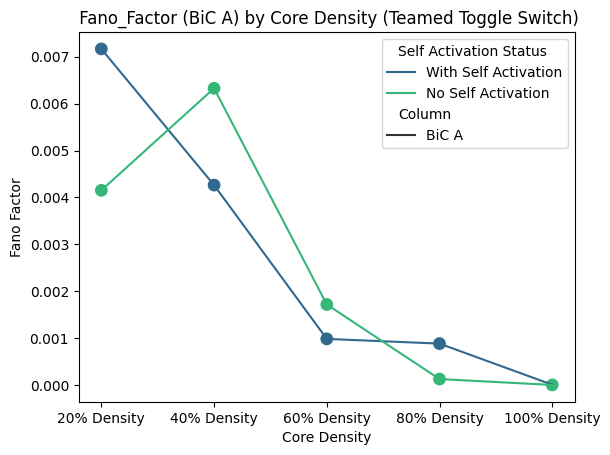

In [141]:
# import seaborn as sns
# import matplotlib.pyplot as plt




# sns.lineplot(x='Core Density', y='Fano Factor', hue='Self Activation Status', style='Column', data=fano_factors_df[fano_factors_df['Column'] == 'BiC A'], palette='viridis')

# # Add scatterplot points with 'x' markers
# sns.scatterplot(x='Core Density', y='Fano Factor', hue='Self Activation Status', legend=False, style='Column', markers=['o'], s=100, data=fano_factors_df[fano_factors_df['Column'] == 'BiC A'], palette='viridis')

# plt.xlabel('Core Density')
# plt.ylabel('Fano Factor')
# plt.title(' Fano_Factor (BiC A) by Core Density (Teamed Toggle Switch)')

# # Show the legend
# #plt.legend(['Self Activation Status','d'])

# # Show the plot
# plt.savefig('plots/Fano_Factor BiC A vs Core Density.png', dpi = 300, bbox_inches='tight')


In [282]:
# import seaborn as sns
# import matplotlib.pyplot as plt




# sns.lineplot(x='Core Density', y='Fano Factor', hue='Self Activation Status',
#               style='Column', data=fano_factors_df[fano_factors_df['Column'] == 'BiC B'], palette='viridis')

# # Add scatterplot points with 'x' markers
# sns.scatterplot(x='Core Density', y='Fano Factor', hue='Self Activation Status', legend=False, style='Column', markers=['o'],
#                  s=100, data=fano_factors_df[fano_factors_df['Column'] == 'BiC B'], palette='viridis')

# plt.xlabel('Core Density')
# plt.ylabel('Fano Factor')
# plt.title(' Fano_Factor (BiC B) by Core Density (Teamed Toggle Switch)')

# # Show the legend
# #plt.legend(['Self Activation Status','d'])

# # Show the plot
# plt.savefig('plots/Fano_Factor BiC B vs Core Density.png', dpi = 300, bbox_inches='tight')


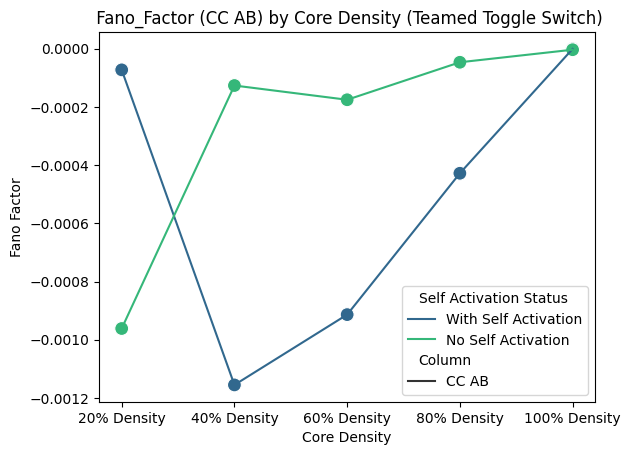

In [143]:
# import seaborn as sns
# import matplotlib.pyplot as plt




# sns.lineplot(x='Core Density', y='Fano Factor', hue='Self Activation Status',
#               style='Column', data=fano_factors_df[fano_factors_df['Column'] == 'CC AB'], palette='viridis')

# # Add scatterplot points with 'x' markers
# sns.scatterplot(x='Core Density', y='Fano Factor', hue='Self Activation Status', legend=False, style='Column', markers=['o'],
#                  s=100, data=fano_factors_df[fano_factors_df['Column'] == 'CC AB'], palette='viridis')

# plt.xlabel('Core Density')
# plt.ylabel('Fano Factor')
# plt.title(' Fano_Factor (CC AB) by Core Density (Teamed Toggle Switch)')

# # Show the legend
# #plt.legend(['Self Activation Status','d'])

# # Show the plot
# plt.savefig('plots/Fano_Factor CC AB vs Core Density.png', dpi = 300, bbox_inches='tight')


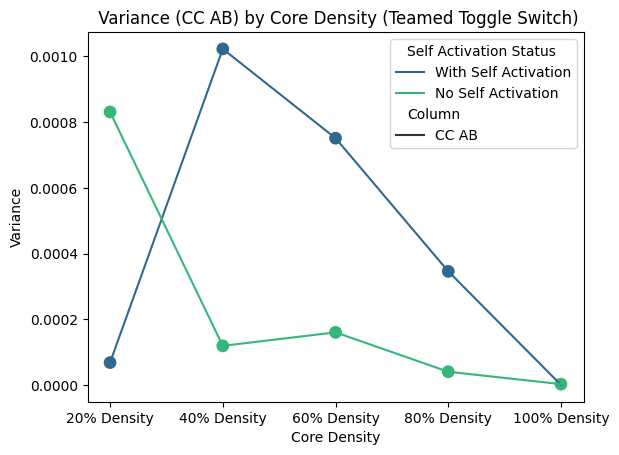

In [144]:
# import seaborn as sns
# import matplotlib.pyplot as plt




# sns.lineplot(x='Core Density', y='Variance', hue='Self Activation Status',
#               style='Column', data=fano_factors_df[fano_factors_df['Column'] == 'CC AB'], palette='viridis')

# # Add scatterplot points with 'x' markers
# sns.scatterplot(x='Core Density', y='Variance', hue='Self Activation Status', legend=False, style='Column', markers=['o'],
#                  s=100, data=fano_factors_df[fano_factors_df['Column'] == 'CC AB'], palette='viridis')

# plt.xlabel('Core Density')
# plt.ylabel('Variance')
# plt.title(' Variance (CC AB) by Core Density (Teamed Toggle Switch)')

# # Show the legend
# #plt.legend(['Self Activation Status','d'])

# # Show the plot
# plt.savefig('plots/Variance CC AB vs Core Density.png', dpi = 300, bbox_inches='tight')


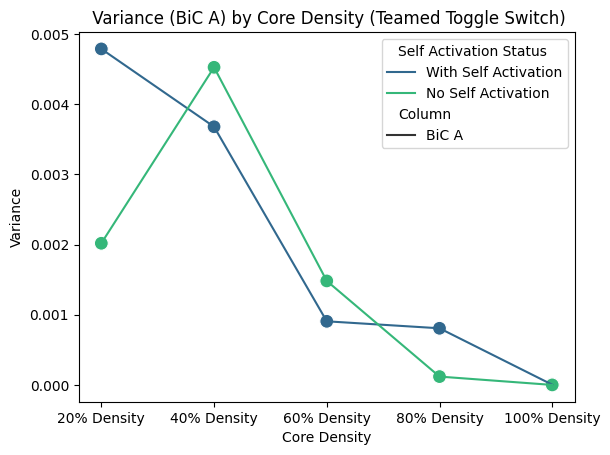

In [145]:
# import seaborn as sns
# import matplotlib.pyplot as plt




# sns.lineplot(x='Core Density', y='Variance', hue='Self Activation Status',
#               style='Column', data=fano_factors_df[fano_factors_df['Column'] == 'BiC A'], palette='viridis')

# # Add scatterplot points with 'x' markers
# sns.scatterplot(x='Core Density', y='Variance', hue='Self Activation Status', legend=False, style='Column', markers=['o'],
#                  s=100, data=fano_factors_df[fano_factors_df['Column'] == 'BiC A'], palette='viridis')

# plt.xlabel('Core Density')
# plt.ylabel('Variance')
# plt.title(' Variance (BiC A) by Core Density (Teamed Toggle Switch)')

# # Show the legend
# #plt.legend(['Self Activation Status','d'])

# # Show the plot
# plt.savefig('plots/Variance BiC A vs Core Density.png', dpi = 300, bbox_inches='tight')
